# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

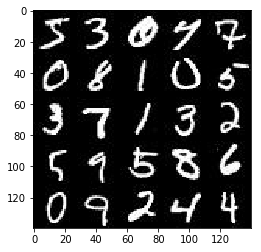

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

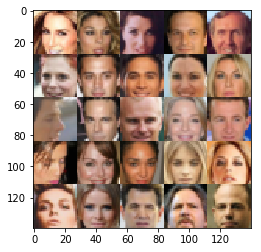

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    learning_rate = tf.placeholder(tf.float32, (None), name='learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    # For reusability
    with tf.variable_scope('discriminator', reuse=reuse):
        # 28x28x1 
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding= 'same')
        relu1 = tf.maximum(0.2 * x1, x1)
        # 14x14x64
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding= 'same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(bn2 * 0.2, bn2)
        # 7x7x128
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding= 'same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(bn3 * 0.2, bn3)
        # 4x4x256
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    # For reusability
    reuse = not is_train
    with tf.variable_scope('generator', reuse= reuse):
        # Fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training = (not is_train))
        x1 = tf.maximum(x1 * 0.2, x1)
        # 4x4x512
        
        # 4 x 4
        # 7 = 4 * s
        #out_height = ceil(float(in_height) / float(strides[1]))
        #out_width = ceil(float(in_width) / float(strides[2]))
        
        #out_height = ceil(float(in_height * float(strides[1]) + filter_height - 1 / float(strides[1]))  = (7 * 2 + 5 - 1) = 18
        #out_width  = ceil(float(in_width * float(strides[2]) + filter_width - 1 / float(strides[2])))    = (7 * 2 + 5 - 1) = 18
        
        # Convolution 1
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(0.2 * x2, x2)
        # 7x7s256
        
        # Convolution 2
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(0.2 * x3, x3)
        # 14x14x128
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5,strides=2,padding='same')
        # 28x28xout_channel_dim
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake))) 
    
    g_loss =  tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    
    return d_loss_real + d_loss_fake, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    # Optimization
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_op = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_op


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
class MY_GAN:
    def __init__(self, real_size, z_size, learning_rate, beta1= 0.5):
#         tf.reset_default_graph()
        print(real_size[1])
        print(real_size[2])
        print(real_size[3])
        self.input_real, self.input_z, self.learning_rate = model_inputs(real_size[1],
                                                     real_size[2],
                                                     real_size[3],
                                                     z_size)
        self.d_loss, self.g_loss = model_loss(self.input_real,
                                              self.input_z,
                                              real_size[3])
        self.d_opt, self.g_opt = model_opt(self.d_loss,
                                           self.g_loss,
                                           learning_rate,
                                           beta1)
        
losses = []

In [35]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Main vars
#     saver = tf.train.Saver()
#     sample_z = np.random.uniform(-1, 1, size=(72, z_size))

#     losses = []
    steps = 0
    global losses
    losses = []
    print(data_shape)
    my_net = MY_GAN(data_shape, z_dim, learning_rate, beta1 = beta1)
    
    with tf.Session() as sess:

        sess.run(tf.global_variables_initializer())
        for e in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Make random noise
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # optimizer
                _ = sess.run(my_net.d_opt, feed_dict = {my_net.input_real: batch_images, my_net.input_z: batch_z})
                _ = sess.run(my_net.g_opt, feed_dict={my_net.input_z: batch_z, my_net.input_real: batch_images})
                _ = sess.run(my_net.g_opt, feed_dict={my_net.input_z: batch_z, my_net.input_real: batch_images})
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = my_net.d_loss.eval({my_net.input_z: batch_z, my_net.input_real: batch_images})
                    train_loss_g = my_net.g_loss.eval({my_net.input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    generator_sample = show_generator_output(sess,
                                                             n_images = 30,
                                                             input_z = my_net.input_z,
                                                             out_channel_dim = data_shape[3],
                                                             image_mode = data_image_mode)
#                     gen_samples = sess.run(
#                                    generator(my_net.input_z, 3, is_train=False),
#                                    feed_dict={my_net.input_z: sample_z})
# #                     _ = view_samples(-1, samples, 6, 12, figsize=figsize)
#                     plt.show()
        
#         saver.save(sess, './checkpoints/generator.ckpt')
#     with open('samples.pkl', 'wb') as f:
#         pkl.dump(samples, f)

                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(60000, 28, 28, 1)
28
28
1
Epoch 1/2... Discriminator Loss: 1.3491... Generator Loss: 1.1486
Epoch 1/2... Discriminator Loss: 4.3770... Generator Loss: 0.0167
Epoch 1/2... Discriminator Loss: 3.2148... Generator Loss: 0.0627
Epoch 1/2... Discriminator Loss: 3.6414... Generator Loss: 0.0603
Epoch 1/2... Discriminator Loss: 2.6477... Generator Loss: 0.1439
Epoch 1/2... Discriminator Loss: 2.8709... Generator Loss: 0.1328
Epoch 1/2... Discriminator Loss: 1.9033... Generator Loss: 0.5762
Epoch 1/2... Discriminator Loss: 1.9486... Generator Loss: 0.8239
Epoch 1/2... Discriminator Loss: 1.4646... Generator Loss: 0.8533
Epoch 1/2... Discriminator Loss: 1.2525... Generator Loss: 1.4331


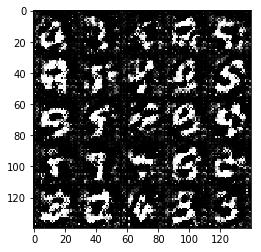

Epoch 1/2... Discriminator Loss: 0.9865... Generator Loss: 1.4562
Epoch 1/2... Discriminator Loss: 0.5669... Generator Loss: 1.7030
Epoch 1/2... Discriminator Loss: 0.4006... Generator Loss: 1.9919
Epoch 1/2... Discriminator Loss: 1.1415... Generator Loss: 1.3270
Epoch 1/2... Discriminator Loss: 1.2739... Generator Loss: 0.3922
Epoch 1/2... Discriminator Loss: 2.4140... Generator Loss: 0.1143
Epoch 1/2... Discriminator Loss: 1.3756... Generator Loss: 0.4416
Epoch 1/2... Discriminator Loss: 1.2969... Generator Loss: 3.1678
Epoch 1/2... Discriminator Loss: 2.3444... Generator Loss: 0.1307
Epoch 1/2... Discriminator Loss: 2.2763... Generator Loss: 0.2164


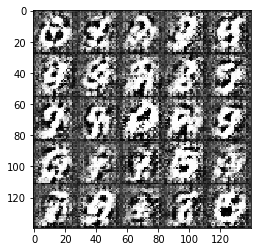

Epoch 1/2... Discriminator Loss: 1.5326... Generator Loss: 0.4840
Epoch 1/2... Discriminator Loss: 0.6171... Generator Loss: 1.8344
Epoch 1/2... Discriminator Loss: 0.9124... Generator Loss: 1.3618
Epoch 1/2... Discriminator Loss: 1.5796... Generator Loss: 0.4015
Epoch 1/2... Discriminator Loss: 1.5468... Generator Loss: 0.6102
Epoch 1/2... Discriminator Loss: 1.0899... Generator Loss: 0.7254
Epoch 1/2... Discriminator Loss: 0.8607... Generator Loss: 1.0219
Epoch 1/2... Discriminator Loss: 2.2722... Generator Loss: 0.1389
Epoch 1/2... Discriminator Loss: 1.8603... Generator Loss: 0.2077
Epoch 1/2... Discriminator Loss: 1.6765... Generator Loss: 0.2613


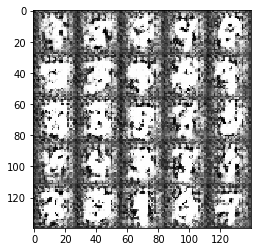

Epoch 1/2... Discriminator Loss: 0.6074... Generator Loss: 1.2495
Epoch 1/2... Discriminator Loss: 0.7673... Generator Loss: 0.9901
Epoch 1/2... Discriminator Loss: 1.5594... Generator Loss: 0.3174
Epoch 1/2... Discriminator Loss: 1.5072... Generator Loss: 0.3121
Epoch 1/2... Discriminator Loss: 0.5795... Generator Loss: 1.2423
Epoch 1/2... Discriminator Loss: 2.6312... Generator Loss: 0.0971
Epoch 1/2... Discriminator Loss: 0.8199... Generator Loss: 0.9605
Epoch 1/2... Discriminator Loss: 0.5400... Generator Loss: 1.6817
Epoch 1/2... Discriminator Loss: 1.5282... Generator Loss: 0.2812
Epoch 1/2... Discriminator Loss: 0.6317... Generator Loss: 0.9618


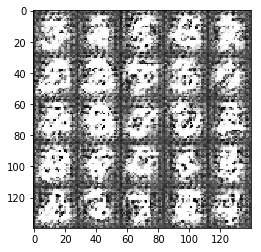

Epoch 1/2... Discriminator Loss: 0.5739... Generator Loss: 1.0162
Epoch 1/2... Discriminator Loss: 1.8870... Generator Loss: 0.2119
Epoch 1/2... Discriminator Loss: 0.5219... Generator Loss: 1.2634
Epoch 1/2... Discriminator Loss: 0.4694... Generator Loss: 1.3514
Epoch 1/2... Discriminator Loss: 0.5374... Generator Loss: 1.0967
Epoch 1/2... Discriminator Loss: 0.8655... Generator Loss: 0.6097
Epoch 1/2... Discriminator Loss: 0.4829... Generator Loss: 1.1850
Epoch 1/2... Discriminator Loss: 0.0905... Generator Loss: 3.3495
Epoch 1/2... Discriminator Loss: 1.8485... Generator Loss: 0.6776
Epoch 1/2... Discriminator Loss: 1.8515... Generator Loss: 0.2773


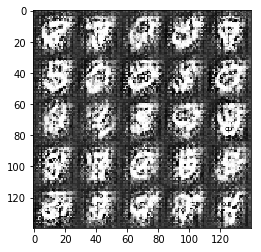

Epoch 1/2... Discriminator Loss: 1.5793... Generator Loss: 0.9367
Epoch 1/2... Discriminator Loss: 1.7657... Generator Loss: 0.6655
Epoch 1/2... Discriminator Loss: 1.2635... Generator Loss: 0.9207
Epoch 1/2... Discriminator Loss: 1.1308... Generator Loss: 0.6358
Epoch 1/2... Discriminator Loss: 1.5393... Generator Loss: 0.3573
Epoch 1/2... Discriminator Loss: 1.2612... Generator Loss: 0.4852
Epoch 1/2... Discriminator Loss: 2.6777... Generator Loss: 0.0798
Epoch 1/2... Discriminator Loss: 1.3403... Generator Loss: 0.4013
Epoch 1/2... Discriminator Loss: 1.7444... Generator Loss: 0.2467
Epoch 1/2... Discriminator Loss: 2.2899... Generator Loss: 0.1224


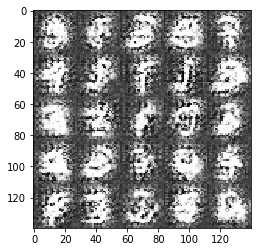

Epoch 1/2... Discriminator Loss: 1.5069... Generator Loss: 0.2893
Epoch 1/2... Discriminator Loss: 0.2818... Generator Loss: 2.0974
Epoch 1/2... Discriminator Loss: 1.3469... Generator Loss: 0.6791
Epoch 1/2... Discriminator Loss: 1.5053... Generator Loss: 0.3562
Epoch 1/2... Discriminator Loss: 2.2381... Generator Loss: 0.1463
Epoch 1/2... Discriminator Loss: 0.9383... Generator Loss: 0.5911
Epoch 1/2... Discriminator Loss: 0.3262... Generator Loss: 3.8444
Epoch 1/2... Discriminator Loss: 0.4608... Generator Loss: 1.2574
Epoch 1/2... Discriminator Loss: 0.0954... Generator Loss: 3.0737
Epoch 1/2... Discriminator Loss: 1.9515... Generator Loss: 0.2029


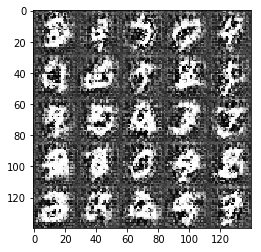

Epoch 1/2... Discriminator Loss: 1.5928... Generator Loss: 0.3162
Epoch 1/2... Discriminator Loss: 3.7044... Generator Loss: 0.0316
Epoch 1/2... Discriminator Loss: 0.7039... Generator Loss: 0.8557
Epoch 1/2... Discriminator Loss: 0.8871... Generator Loss: 0.6316
Epoch 1/2... Discriminator Loss: 0.2612... Generator Loss: 1.7317
Epoch 1/2... Discriminator Loss: 0.0714... Generator Loss: 3.1931
Epoch 1/2... Discriminator Loss: 0.0438... Generator Loss: 5.0830
Epoch 1/2... Discriminator Loss: 4.5368... Generator Loss: 0.0144
Epoch 1/2... Discriminator Loss: 2.8177... Generator Loss: 0.0751
Epoch 1/2... Discriminator Loss: 1.6752... Generator Loss: 0.2562


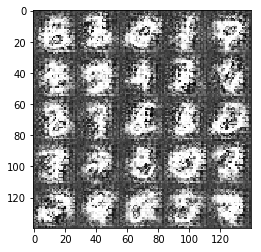

Epoch 1/2... Discriminator Loss: 1.6051... Generator Loss: 0.2664
Epoch 1/2... Discriminator Loss: 0.9546... Generator Loss: 4.5031
Epoch 1/2... Discriminator Loss: 1.1736... Generator Loss: 1.0068
Epoch 1/2... Discriminator Loss: 1.0203... Generator Loss: 1.0540
Epoch 1/2... Discriminator Loss: 0.8997... Generator Loss: 0.6569
Epoch 1/2... Discriminator Loss: 2.8820... Generator Loss: 4.0071
Epoch 1/2... Discriminator Loss: 0.3749... Generator Loss: 1.7574
Epoch 1/2... Discriminator Loss: 2.2295... Generator Loss: 0.1540
Epoch 1/2... Discriminator Loss: 0.1297... Generator Loss: 2.6964
Epoch 1/2... Discriminator Loss: 0.1029... Generator Loss: 3.0504


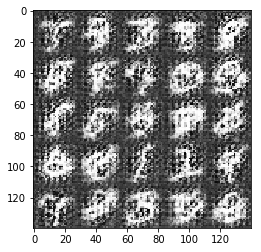

Epoch 1/2... Discriminator Loss: 0.8201... Generator Loss: 0.7030
Epoch 1/2... Discriminator Loss: 0.0611... Generator Loss: 3.6360
Epoch 1/2... Discriminator Loss: 0.0375... Generator Loss: 4.5244
Epoch 1/2... Discriminator Loss: 0.0631... Generator Loss: 3.2277
Epoch 1/2... Discriminator Loss: 0.5274... Generator Loss: 1.1105
Epoch 1/2... Discriminator Loss: 0.7928... Generator Loss: 0.7917
Epoch 1/2... Discriminator Loss: 1.1127... Generator Loss: 0.4892
Epoch 1/2... Discriminator Loss: 0.8928... Generator Loss: 0.6133
Epoch 1/2... Discriminator Loss: 0.0224... Generator Loss: 4.7464
Epoch 1/2... Discriminator Loss: 0.4534... Generator Loss: 1.2975


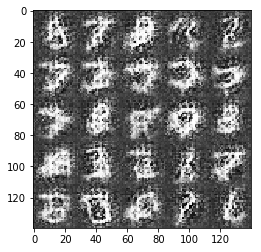

Epoch 1/2... Discriminator Loss: 0.0215... Generator Loss: 5.3295
Epoch 1/2... Discriminator Loss: 0.8938... Generator Loss: 0.6344
Epoch 1/2... Discriminator Loss: 2.1535... Generator Loss: 0.1632
Epoch 1/2... Discriminator Loss: 1.2736... Generator Loss: 0.4502
Epoch 1/2... Discriminator Loss: 1.0200... Generator Loss: 0.5369
Epoch 1/2... Discriminator Loss: 1.4778... Generator Loss: 0.3161
Epoch 1/2... Discriminator Loss: 1.6059... Generator Loss: 0.2728
Epoch 1/2... Discriminator Loss: 0.6907... Generator Loss: 0.8205
Epoch 1/2... Discriminator Loss: 1.1094... Generator Loss: 0.7343
Epoch 1/2... Discriminator Loss: 1.7225... Generator Loss: 0.2446


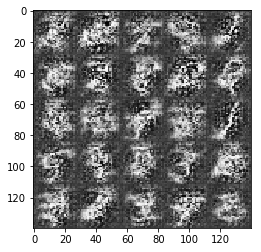

Epoch 1/2... Discriminator Loss: 2.0486... Generator Loss: 0.1641
Epoch 1/2... Discriminator Loss: 1.1425... Generator Loss: 2.0379
Epoch 1/2... Discriminator Loss: 0.5590... Generator Loss: 1.1266
Epoch 1/2... Discriminator Loss: 0.4175... Generator Loss: 2.0562
Epoch 1/2... Discriminator Loss: 1.2484... Generator Loss: 1.0723
Epoch 1/2... Discriminator Loss: 1.0970... Generator Loss: 1.3833
Epoch 1/2... Discriminator Loss: 1.4029... Generator Loss: 0.3495
Epoch 1/2... Discriminator Loss: 1.0485... Generator Loss: 0.9170
Epoch 1/2... Discriminator Loss: 0.8455... Generator Loss: 1.2429
Epoch 1/2... Discriminator Loss: 1.4973... Generator Loss: 0.3108


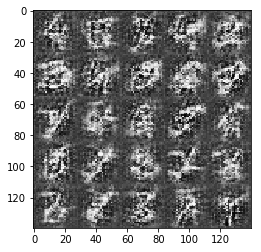

Epoch 1/2... Discriminator Loss: 0.9083... Generator Loss: 2.8058
Epoch 1/2... Discriminator Loss: 0.7970... Generator Loss: 0.8959
Epoch 1/2... Discriminator Loss: 0.5292... Generator Loss: 1.1164
Epoch 1/2... Discriminator Loss: 0.3196... Generator Loss: 2.1607
Epoch 1/2... Discriminator Loss: 0.0604... Generator Loss: 4.4859
Epoch 1/2... Discriminator Loss: 1.6027... Generator Loss: 0.3274
Epoch 1/2... Discriminator Loss: 1.3890... Generator Loss: 0.3524
Epoch 1/2... Discriminator Loss: 0.2582... Generator Loss: 1.8032
Epoch 1/2... Discriminator Loss: 0.5159... Generator Loss: 1.1207
Epoch 1/2... Discriminator Loss: 2.7321... Generator Loss: 0.0975


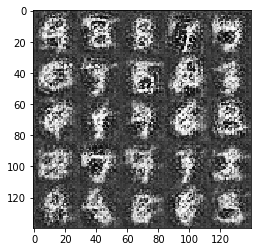

Epoch 1/2... Discriminator Loss: 1.1719... Generator Loss: 0.5182
Epoch 1/2... Discriminator Loss: 0.3740... Generator Loss: 1.4808
Epoch 1/2... Discriminator Loss: 0.5435... Generator Loss: 1.0109
Epoch 1/2... Discriminator Loss: 1.1166... Generator Loss: 0.4620
Epoch 1/2... Discriminator Loss: 0.2093... Generator Loss: 1.9886
Epoch 1/2... Discriminator Loss: 2.4192... Generator Loss: 0.1360
Epoch 1/2... Discriminator Loss: 1.3164... Generator Loss: 0.4265
Epoch 1/2... Discriminator Loss: 0.4097... Generator Loss: 1.2918
Epoch 1/2... Discriminator Loss: 1.5004... Generator Loss: 0.3179
Epoch 1/2... Discriminator Loss: 0.1525... Generator Loss: 2.2803


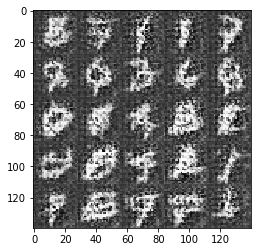

Epoch 1/2... Discriminator Loss: 0.5942... Generator Loss: 0.9713
Epoch 1/2... Discriminator Loss: 0.0354... Generator Loss: 5.6115
Epoch 1/2... Discriminator Loss: 0.1044... Generator Loss: 2.7313
Epoch 1/2... Discriminator Loss: 0.1095... Generator Loss: 2.7081
Epoch 1/2... Discriminator Loss: 0.9179... Generator Loss: 0.6653
Epoch 1/2... Discriminator Loss: 0.0757... Generator Loss: 3.1191
Epoch 1/2... Discriminator Loss: 0.4835... Generator Loss: 1.1203
Epoch 1/2... Discriminator Loss: 0.5490... Generator Loss: 1.1312
Epoch 1/2... Discriminator Loss: 2.0767... Generator Loss: 0.1930
Epoch 1/2... Discriminator Loss: 5.9938... Generator Loss: 6.9179


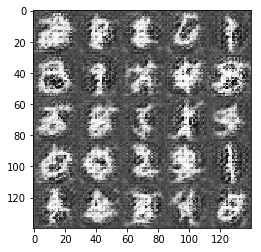

Epoch 1/2... Discriminator Loss: 0.9890... Generator Loss: 1.3110
Epoch 1/2... Discriminator Loss: 2.2720... Generator Loss: 0.1626
Epoch 1/2... Discriminator Loss: 2.4508... Generator Loss: 0.1173
Epoch 1/2... Discriminator Loss: 1.4669... Generator Loss: 1.8536
Epoch 1/2... Discriminator Loss: 1.4632... Generator Loss: 0.3562
Epoch 1/2... Discriminator Loss: 1.1382... Generator Loss: 0.5729
Epoch 1/2... Discriminator Loss: 0.3747... Generator Loss: 2.0532
Epoch 1/2... Discriminator Loss: 2.3243... Generator Loss: 0.1213
Epoch 1/2... Discriminator Loss: 1.1058... Generator Loss: 0.8605
Epoch 1/2... Discriminator Loss: 1.2129... Generator Loss: 0.5016


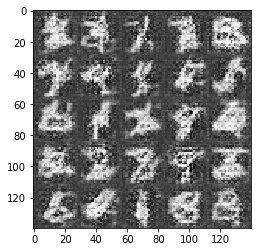

Epoch 1/2... Discriminator Loss: 1.0934... Generator Loss: 1.9617
Epoch 1/2... Discriminator Loss: 0.7702... Generator Loss: 0.7513
Epoch 1/2... Discriminator Loss: 1.6869... Generator Loss: 0.2895
Epoch 1/2... Discriminator Loss: 0.8138... Generator Loss: 0.7304
Epoch 1/2... Discriminator Loss: 1.6755... Generator Loss: 0.2605
Epoch 1/2... Discriminator Loss: 0.1234... Generator Loss: 2.7017
Epoch 1/2... Discriminator Loss: 3.2951... Generator Loss: 0.0570
Epoch 1/2... Discriminator Loss: 0.1159... Generator Loss: 2.6107
Epoch 1/2... Discriminator Loss: 2.4331... Generator Loss: 0.1353
Epoch 1/2... Discriminator Loss: 1.1098... Generator Loss: 0.5093


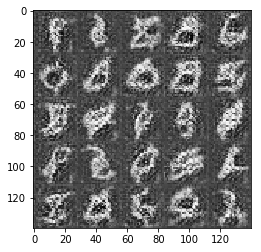

Epoch 1/2... Discriminator Loss: 0.8661... Generator Loss: 0.8671
Epoch 1/2... Discriminator Loss: 1.6634... Generator Loss: 3.6420
Epoch 1/2... Discriminator Loss: 1.0895... Generator Loss: 0.5423
Epoch 1/2... Discriminator Loss: 2.1807... Generator Loss: 1.9688
Epoch 1/2... Discriminator Loss: 1.0304... Generator Loss: 0.9413
Epoch 1/2... Discriminator Loss: 1.7864... Generator Loss: 0.2485
Epoch 1/2... Discriminator Loss: 2.4509... Generator Loss: 2.1907
Epoch 1/2... Discriminator Loss: 0.7889... Generator Loss: 1.1484
Epoch 1/2... Discriminator Loss: 1.0714... Generator Loss: 0.5143
Epoch 1/2... Discriminator Loss: 1.3363... Generator Loss: 0.4479


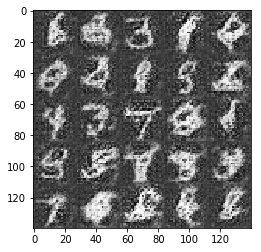

Epoch 1/2... Discriminator Loss: 0.3260... Generator Loss: 1.6221
Epoch 1/2... Discriminator Loss: 0.6274... Generator Loss: 0.9251
Epoch 1/2... Discriminator Loss: 1.8785... Generator Loss: 0.2151
Epoch 1/2... Discriminator Loss: 0.7507... Generator Loss: 0.7536
Epoch 1/2... Discriminator Loss: 0.9736... Generator Loss: 0.5899
Epoch 1/2... Discriminator Loss: 0.0955... Generator Loss: 2.9762
Epoch 1/2... Discriminator Loss: 0.6125... Generator Loss: 0.9773
Epoch 2/2... Discriminator Loss: 0.5233... Generator Loss: 1.0754
Epoch 2/2... Discriminator Loss: 0.3440... Generator Loss: 1.4369
Epoch 2/2... Discriminator Loss: 0.1954... Generator Loss: 2.0226


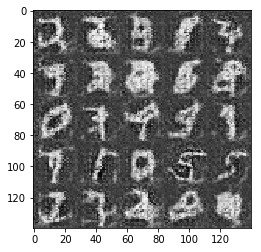

Epoch 2/2... Discriminator Loss: 0.3288... Generator Loss: 1.4330
Epoch 2/2... Discriminator Loss: 1.6057... Generator Loss: 0.3220
Epoch 2/2... Discriminator Loss: 1.5448... Generator Loss: 0.3078
Epoch 2/2... Discriminator Loss: 0.5937... Generator Loss: 1.3335
Epoch 2/2... Discriminator Loss: 0.3566... Generator Loss: 2.0278
Epoch 2/2... Discriminator Loss: 0.8643... Generator Loss: 0.7436
Epoch 2/2... Discriminator Loss: 1.9531... Generator Loss: 0.2293
Epoch 2/2... Discriminator Loss: 1.5820... Generator Loss: 0.3783
Epoch 2/2... Discriminator Loss: 0.1887... Generator Loss: 2.2372
Epoch 2/2... Discriminator Loss: 1.3579... Generator Loss: 0.3967


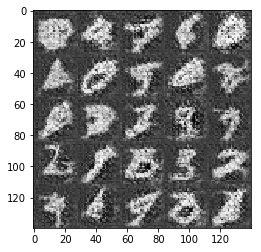

Epoch 2/2... Discriminator Loss: 0.7348... Generator Loss: 0.8578
Epoch 2/2... Discriminator Loss: 0.5393... Generator Loss: 1.1013
Epoch 2/2... Discriminator Loss: 0.4986... Generator Loss: 1.1625
Epoch 2/2... Discriminator Loss: 0.3797... Generator Loss: 1.3467
Epoch 2/2... Discriminator Loss: 2.0949... Generator Loss: 0.1895
Epoch 2/2... Discriminator Loss: 0.4690... Generator Loss: 1.2505
Epoch 2/2... Discriminator Loss: 1.4043... Generator Loss: 0.3894
Epoch 2/2... Discriminator Loss: 2.5995... Generator Loss: 0.0985
Epoch 2/2... Discriminator Loss: 0.9220... Generator Loss: 1.2948
Epoch 2/2... Discriminator Loss: 1.2496... Generator Loss: 2.5900


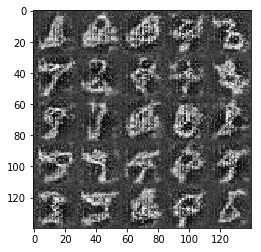

Epoch 2/2... Discriminator Loss: 0.9015... Generator Loss: 0.7311
Epoch 2/2... Discriminator Loss: 1.0470... Generator Loss: 0.5480
Epoch 2/2... Discriminator Loss: 0.9236... Generator Loss: 0.7105
Epoch 2/2... Discriminator Loss: 0.4774... Generator Loss: 2.4792
Epoch 2/2... Discriminator Loss: 1.3153... Generator Loss: 1.9220
Epoch 2/2... Discriminator Loss: 1.1797... Generator Loss: 0.4867
Epoch 2/2... Discriminator Loss: 2.3435... Generator Loss: 0.1367
Epoch 2/2... Discriminator Loss: 1.5857... Generator Loss: 0.3450
Epoch 2/2... Discriminator Loss: 0.4977... Generator Loss: 1.1936
Epoch 2/2... Discriminator Loss: 0.0853... Generator Loss: 4.9887


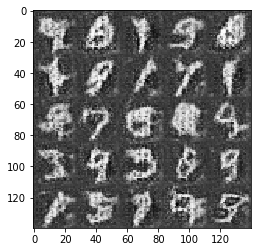

Epoch 2/2... Discriminator Loss: 1.1251... Generator Loss: 0.5793
Epoch 2/2... Discriminator Loss: 1.6451... Generator Loss: 0.2802
Epoch 2/2... Discriminator Loss: 3.1300... Generator Loss: 0.0590
Epoch 2/2... Discriminator Loss: 1.3487... Generator Loss: 0.4215
Epoch 2/2... Discriminator Loss: 0.7765... Generator Loss: 1.1578
Epoch 2/2... Discriminator Loss: 0.8391... Generator Loss: 1.1030
Epoch 2/2... Discriminator Loss: 1.2423... Generator Loss: 0.4342
Epoch 2/2... Discriminator Loss: 1.9241... Generator Loss: 0.2012
Epoch 2/2... Discriminator Loss: 2.7194... Generator Loss: 0.1158
Epoch 2/2... Discriminator Loss: 0.1820... Generator Loss: 2.1873


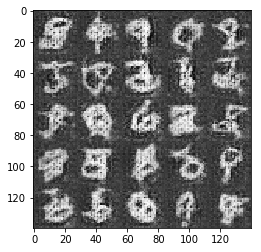

Epoch 2/2... Discriminator Loss: 0.1148... Generator Loss: 2.6446
Epoch 2/2... Discriminator Loss: 0.1201... Generator Loss: 2.4959
Epoch 2/2... Discriminator Loss: 0.1183... Generator Loss: 2.6164
Epoch 2/2... Discriminator Loss: 0.0878... Generator Loss: 2.9595
Epoch 2/2... Discriminator Loss: 0.1080... Generator Loss: 2.9215
Epoch 2/2... Discriminator Loss: 0.0258... Generator Loss: 4.5700
Epoch 2/2... Discriminator Loss: 2.9274... Generator Loss: 0.0697
Epoch 2/2... Discriminator Loss: 0.0831... Generator Loss: 3.0637
Epoch 2/2... Discriminator Loss: 0.8911... Generator Loss: 0.6609
Epoch 2/2... Discriminator Loss: 0.8715... Generator Loss: 0.7039


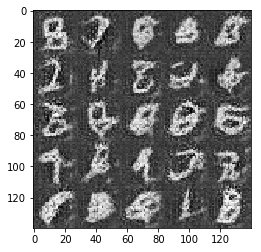

Epoch 2/2... Discriminator Loss: 0.0408... Generator Loss: 3.8441
Epoch 2/2... Discriminator Loss: 2.6155... Generator Loss: 0.1043
Epoch 2/2... Discriminator Loss: 0.0106... Generator Loss: 8.2048
Epoch 2/2... Discriminator Loss: 0.0320... Generator Loss: 3.8607
Epoch 2/2... Discriminator Loss: 5.0359... Generator Loss: 0.0081
Epoch 2/2... Discriminator Loss: 0.5117... Generator Loss: 2.2658
Epoch 2/2... Discriminator Loss: 1.0865... Generator Loss: 0.5042
Epoch 2/2... Discriminator Loss: 0.3849... Generator Loss: 1.5687
Epoch 2/2... Discriminator Loss: 0.6260... Generator Loss: 0.9439
Epoch 2/2... Discriminator Loss: 1.6930... Generator Loss: 0.2598


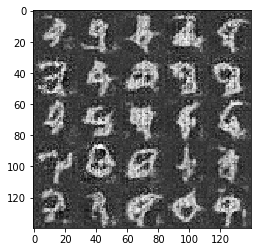

Epoch 2/2... Discriminator Loss: 2.7151... Generator Loss: 4.4881
Epoch 2/2... Discriminator Loss: 0.9966... Generator Loss: 2.3640
Epoch 2/2... Discriminator Loss: 0.9452... Generator Loss: 0.6400
Epoch 2/2... Discriminator Loss: 0.8002... Generator Loss: 0.7876
Epoch 2/2... Discriminator Loss: 1.2130... Generator Loss: 0.4646
Epoch 2/2... Discriminator Loss: 1.7888... Generator Loss: 0.2333
Epoch 2/2... Discriminator Loss: 1.0843... Generator Loss: 0.5711
Epoch 2/2... Discriminator Loss: 2.9641... Generator Loss: 0.0678
Epoch 2/2... Discriminator Loss: 1.9370... Generator Loss: 0.2164
Epoch 2/2... Discriminator Loss: 0.1985... Generator Loss: 2.0461


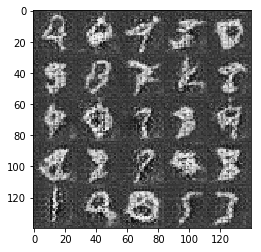

Epoch 2/2... Discriminator Loss: 1.0470... Generator Loss: 0.5672
Epoch 2/2... Discriminator Loss: 0.1922... Generator Loss: 2.2312
Epoch 2/2... Discriminator Loss: 0.6937... Generator Loss: 0.9292
Epoch 2/2... Discriminator Loss: 0.7897... Generator Loss: 1.9420
Epoch 2/2... Discriminator Loss: 0.8065... Generator Loss: 2.2430
Epoch 2/2... Discriminator Loss: 0.5588... Generator Loss: 1.7888
Epoch 2/2... Discriminator Loss: 1.2118... Generator Loss: 0.5801
Epoch 2/2... Discriminator Loss: 1.0457... Generator Loss: 0.5601
Epoch 2/2... Discriminator Loss: 0.6579... Generator Loss: 1.1210
Epoch 2/2... Discriminator Loss: 1.1488... Generator Loss: 2.3513


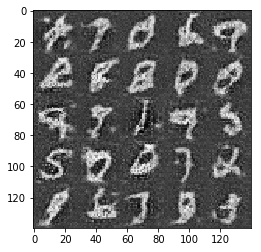

Epoch 2/2... Discriminator Loss: 0.5468... Generator Loss: 1.5144
Epoch 2/2... Discriminator Loss: 2.1940... Generator Loss: 0.1626
Epoch 2/2... Discriminator Loss: 2.1468... Generator Loss: 0.1832
Epoch 2/2... Discriminator Loss: 1.2064... Generator Loss: 0.5228
Epoch 2/2... Discriminator Loss: 1.0925... Generator Loss: 0.5215
Epoch 2/2... Discriminator Loss: 1.4599... Generator Loss: 0.3518
Epoch 2/2... Discriminator Loss: 1.4679... Generator Loss: 0.3329
Epoch 2/2... Discriminator Loss: 0.5821... Generator Loss: 1.0050
Epoch 2/2... Discriminator Loss: 1.5053... Generator Loss: 0.3792
Epoch 2/2... Discriminator Loss: 1.1070... Generator Loss: 0.5167


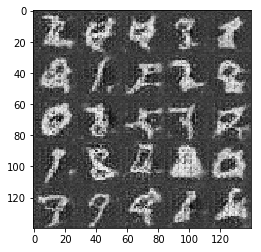

Epoch 2/2... Discriminator Loss: 0.8202... Generator Loss: 0.6815
Epoch 2/2... Discriminator Loss: 0.2196... Generator Loss: 2.0709
Epoch 2/2... Discriminator Loss: 0.6725... Generator Loss: 0.9031
Epoch 2/2... Discriminator Loss: 0.3350... Generator Loss: 3.4818
Epoch 2/2... Discriminator Loss: 2.8089... Generator Loss: 0.0941
Epoch 2/2... Discriminator Loss: 1.5370... Generator Loss: 0.3161
Epoch 2/2... Discriminator Loss: 2.4632... Generator Loss: 0.1187
Epoch 2/2... Discriminator Loss: 2.6423... Generator Loss: 0.1027
Epoch 2/2... Discriminator Loss: 0.0504... Generator Loss: 3.6024
Epoch 2/2... Discriminator Loss: 0.0376... Generator Loss: 3.9233


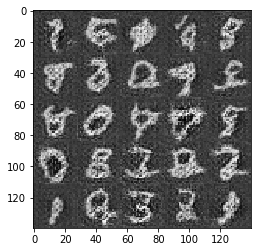

Epoch 2/2... Discriminator Loss: 0.0514... Generator Loss: 3.6398
Epoch 2/2... Discriminator Loss: 1.3995... Generator Loss: 2.9918
Epoch 2/2... Discriminator Loss: 0.5034... Generator Loss: 1.2077
Epoch 2/2... Discriminator Loss: 1.3827... Generator Loss: 0.3502
Epoch 2/2... Discriminator Loss: 1.9058... Generator Loss: 0.2098
Epoch 2/2... Discriminator Loss: 1.2184... Generator Loss: 0.4739
Epoch 2/2... Discriminator Loss: 2.1722... Generator Loss: 0.1939
Epoch 2/2... Discriminator Loss: 1.8733... Generator Loss: 0.2879
Epoch 2/2... Discriminator Loss: 3.6447... Generator Loss: 0.0572
Epoch 2/2... Discriminator Loss: 0.7158... Generator Loss: 0.9650


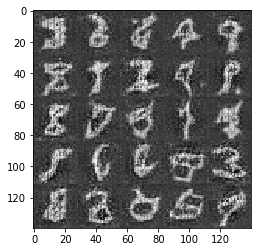

Epoch 2/2... Discriminator Loss: 0.7791... Generator Loss: 1.7583
Epoch 2/2... Discriminator Loss: 1.3303... Generator Loss: 0.3622
Epoch 2/2... Discriminator Loss: 3.9068... Generator Loss: 4.3677
Epoch 2/2... Discriminator Loss: 1.2509... Generator Loss: 0.4531
Epoch 2/2... Discriminator Loss: 0.8058... Generator Loss: 0.8157
Epoch 2/2... Discriminator Loss: 0.0699... Generator Loss: 3.4471
Epoch 2/2... Discriminator Loss: 1.6476... Generator Loss: 0.2979
Epoch 2/2... Discriminator Loss: 0.6137... Generator Loss: 1.0127
Epoch 2/2... Discriminator Loss: 2.7591... Generator Loss: 0.0815
Epoch 2/2... Discriminator Loss: 0.0263... Generator Loss: 4.8690


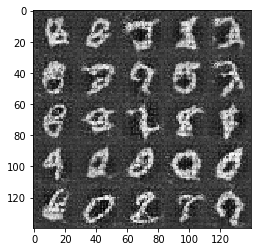

Epoch 2/2... Discriminator Loss: 0.0108... Generator Loss: 5.0824
Epoch 2/2... Discriminator Loss: 1.7714... Generator Loss: 0.2611
Epoch 2/2... Discriminator Loss: 0.1583... Generator Loss: 2.2850
Epoch 2/2... Discriminator Loss: 0.7545... Generator Loss: 0.7918
Epoch 2/2... Discriminator Loss: 0.6538... Generator Loss: 0.9329
Epoch 2/2... Discriminator Loss: 0.1063... Generator Loss: 2.7727
Epoch 2/2... Discriminator Loss: 0.3967... Generator Loss: 1.3497
Epoch 2/2... Discriminator Loss: 3.5298... Generator Loss: 0.0371
Epoch 2/2... Discriminator Loss: 0.2598... Generator Loss: 1.7591
Epoch 2/2... Discriminator Loss: 3.4772... Generator Loss: 0.0605


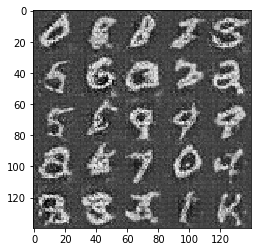

Epoch 2/2... Discriminator Loss: 0.7335... Generator Loss: 1.3516
Epoch 2/2... Discriminator Loss: 0.7158... Generator Loss: 1.2294
Epoch 2/2... Discriminator Loss: 1.6002... Generator Loss: 0.2965
Epoch 2/2... Discriminator Loss: 1.0271... Generator Loss: 0.6173
Epoch 2/2... Discriminator Loss: 0.8782... Generator Loss: 0.7300
Epoch 2/2... Discriminator Loss: 0.8346... Generator Loss: 0.8836
Epoch 2/2... Discriminator Loss: 2.0028... Generator Loss: 0.2146
Epoch 2/2... Discriminator Loss: 1.1263... Generator Loss: 0.5461
Epoch 2/2... Discriminator Loss: 1.9308... Generator Loss: 0.2050
Epoch 2/2... Discriminator Loss: 6.7456... Generator Loss: 5.9890


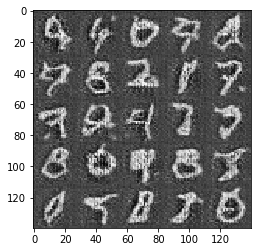

Epoch 2/2... Discriminator Loss: 0.5808... Generator Loss: 1.1722
Epoch 2/2... Discriminator Loss: 0.6909... Generator Loss: 0.9469
Epoch 2/2... Discriminator Loss: 0.9807... Generator Loss: 0.7449
Epoch 2/2... Discriminator Loss: 0.9635... Generator Loss: 0.6230
Epoch 2/2... Discriminator Loss: 2.8301... Generator Loss: 3.3584
Epoch 2/2... Discriminator Loss: 1.6155... Generator Loss: 0.2823
Epoch 2/2... Discriminator Loss: 1.4379... Generator Loss: 0.3825
Epoch 2/2... Discriminator Loss: 1.3735... Generator Loss: 0.4294
Epoch 2/2... Discriminator Loss: 1.9023... Generator Loss: 0.2115
Epoch 2/2... Discriminator Loss: 0.2876... Generator Loss: 1.7242


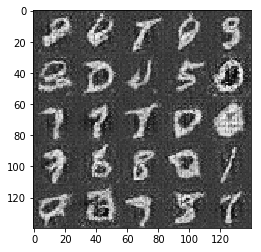

Epoch 2/2... Discriminator Loss: 0.0811... Generator Loss: 3.2292
Epoch 2/2... Discriminator Loss: 0.0678... Generator Loss: 4.8069
Epoch 2/2... Discriminator Loss: 1.3446... Generator Loss: 0.3885
Epoch 2/2... Discriminator Loss: 3.1600... Generator Loss: 0.0578
Epoch 2/2... Discriminator Loss: 0.1715... Generator Loss: 2.1536
Epoch 2/2... Discriminator Loss: 1.3597... Generator Loss: 0.4312
Epoch 2/2... Discriminator Loss: 0.1057... Generator Loss: 2.7351
Epoch 2/2... Discriminator Loss: 0.9421... Generator Loss: 2.7084
Epoch 2/2... Discriminator Loss: 0.8187... Generator Loss: 0.8190
Epoch 2/2... Discriminator Loss: 0.8194... Generator Loss: 0.8224


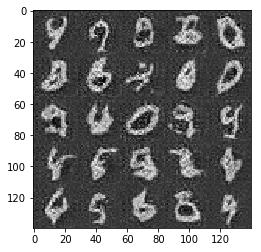

Epoch 2/2... Discriminator Loss: 1.1805... Generator Loss: 0.6392
Epoch 2/2... Discriminator Loss: 2.1188... Generator Loss: 0.1892
Epoch 2/2... Discriminator Loss: 2.4336... Generator Loss: 0.1749
Epoch 2/2... Discriminator Loss: 1.1191... Generator Loss: 0.5315
Epoch 2/2... Discriminator Loss: 0.3865... Generator Loss: 1.3436
Epoch 2/2... Discriminator Loss: 0.9429... Generator Loss: 2.9479
Epoch 2/2... Discriminator Loss: 1.6109... Generator Loss: 0.3038
Epoch 2/2... Discriminator Loss: 0.6441... Generator Loss: 0.9816
Epoch 2/2... Discriminator Loss: 0.6203... Generator Loss: 2.1826
Epoch 2/2... Discriminator Loss: 0.5645... Generator Loss: 1.2151


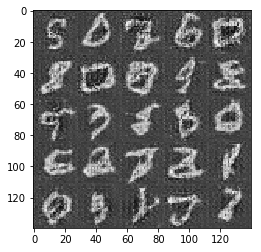

Epoch 2/2... Discriminator Loss: 0.8322... Generator Loss: 0.8332
Epoch 2/2... Discriminator Loss: 1.3080... Generator Loss: 0.4955
Epoch 2/2... Discriminator Loss: 0.9205... Generator Loss: 0.7291
Epoch 2/2... Discriminator Loss: 3.0339... Generator Loss: 0.0720
Epoch 2/2... Discriminator Loss: 0.9205... Generator Loss: 0.7291
Epoch 2/2... Discriminator Loss: 1.7218... Generator Loss: 0.2701
Epoch 2/2... Discriminator Loss: 0.8080... Generator Loss: 0.7904
Epoch 2/2... Discriminator Loss: 0.0469... Generator Loss: 3.8981
Epoch 2/2... Discriminator Loss: 3.5364... Generator Loss: 0.0389
Epoch 2/2... Discriminator Loss: 0.7055... Generator Loss: 0.8454


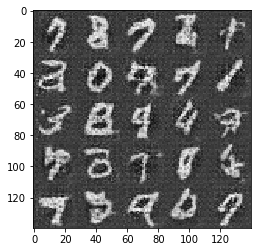

Epoch 2/2... Discriminator Loss: 0.8460... Generator Loss: 0.7728
Epoch 2/2... Discriminator Loss: 0.0526... Generator Loss: 4.1701
Epoch 2/2... Discriminator Loss: 0.0481... Generator Loss: 3.6230
Epoch 2/2... Discriminator Loss: 0.7054... Generator Loss: 0.9025
Epoch 2/2... Discriminator Loss: 0.2012... Generator Loss: 2.2772


In [38]:
batch_size = 32 #32
z_dim = 300 #150
learning_rate = 0.0005
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

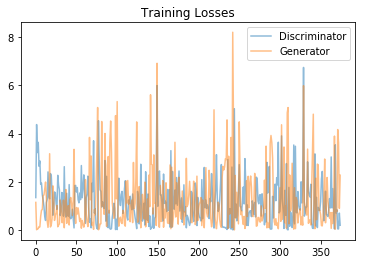

In [39]:
plt = pyplot
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(202599, 28, 28, 3)
28
28
3
Epoch 1/1... Discriminator Loss: 4.7658... Generator Loss: 0.0192
Epoch 1/1... Discriminator Loss: 5.4223... Generator Loss: 0.0066
Epoch 1/1... Discriminator Loss: 1.3154... Generator Loss: 2.9951
Epoch 1/1... Discriminator Loss: 1.7316... Generator Loss: 1.3477
Epoch 1/1... Discriminator Loss: 1.8130... Generator Loss: 0.6536
Epoch 1/1... Discriminator Loss: 1.5702... Generator Loss: 0.9952
Epoch 1/1... Discriminator Loss: 1.4689... Generator Loss: 1.3100
Epoch 1/1... Discriminator Loss: 1.5051... Generator Loss: 0.5488
Epoch 1/1... Discriminator Loss: 1.6137... Generator Loss: 0.2824
Epoch 1/1... Discriminator Loss: 1.7940... Generator Loss: 0.3001


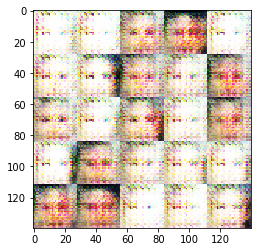

Epoch 1/1... Discriminator Loss: 3.2703... Generator Loss: 0.0535
Epoch 1/1... Discriminator Loss: 2.2521... Generator Loss: 0.1648
Epoch 1/1... Discriminator Loss: 1.4582... Generator Loss: 0.9187
Epoch 1/1... Discriminator Loss: 1.4721... Generator Loss: 0.8020
Epoch 1/1... Discriminator Loss: 2.4681... Generator Loss: 0.1365
Epoch 1/1... Discriminator Loss: 2.4354... Generator Loss: 0.1792
Epoch 1/1... Discriminator Loss: 1.2548... Generator Loss: 1.0484
Epoch 1/1... Discriminator Loss: 2.0009... Generator Loss: 0.3599
Epoch 1/1... Discriminator Loss: 1.0477... Generator Loss: 0.9660
Epoch 1/1... Discriminator Loss: 1.4349... Generator Loss: 0.5222


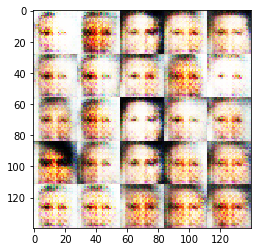

Epoch 1/1... Discriminator Loss: 1.5943... Generator Loss: 0.3360
Epoch 1/1... Discriminator Loss: 1.0108... Generator Loss: 1.1673
Epoch 1/1... Discriminator Loss: 0.9039... Generator Loss: 0.7800
Epoch 1/1... Discriminator Loss: 2.2219... Generator Loss: 0.1501
Epoch 1/1... Discriminator Loss: 0.7086... Generator Loss: 0.9232
Epoch 1/1... Discriminator Loss: 0.4534... Generator Loss: 1.4050
Epoch 1/1... Discriminator Loss: 0.7305... Generator Loss: 2.7044
Epoch 1/1... Discriminator Loss: 0.5246... Generator Loss: 1.7059
Epoch 1/1... Discriminator Loss: 1.1741... Generator Loss: 0.4702
Epoch 1/1... Discriminator Loss: 0.7981... Generator Loss: 1.0412


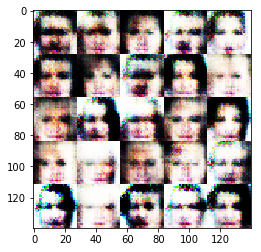

Epoch 1/1... Discriminator Loss: 0.9499... Generator Loss: 0.7684
Epoch 1/1... Discriminator Loss: 0.4427... Generator Loss: 1.2293
Epoch 1/1... Discriminator Loss: 0.0957... Generator Loss: 3.4519
Epoch 1/1... Discriminator Loss: 1.4755... Generator Loss: 0.9536
Epoch 1/1... Discriminator Loss: 1.2616... Generator Loss: 0.4516
Epoch 1/1... Discriminator Loss: 0.5735... Generator Loss: 1.5916
Epoch 1/1... Discriminator Loss: 0.5060... Generator Loss: 1.2531
Epoch 1/1... Discriminator Loss: 2.5750... Generator Loss: 0.1186
Epoch 1/1... Discriminator Loss: 0.9924... Generator Loss: 2.7814
Epoch 1/1... Discriminator Loss: 0.9691... Generator Loss: 0.6614


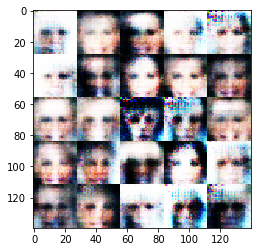

Epoch 1/1... Discriminator Loss: 2.1339... Generator Loss: 5.2296
Epoch 1/1... Discriminator Loss: 0.2722... Generator Loss: 2.7414
Epoch 1/1... Discriminator Loss: 0.3359... Generator Loss: 2.1398
Epoch 1/1... Discriminator Loss: 0.5094... Generator Loss: 1.3843
Epoch 1/1... Discriminator Loss: 2.3645... Generator Loss: 0.1554
Epoch 1/1... Discriminator Loss: 0.2896... Generator Loss: 2.6830
Epoch 1/1... Discriminator Loss: 2.0516... Generator Loss: 0.1889
Epoch 1/1... Discriminator Loss: 1.1765... Generator Loss: 0.4688
Epoch 1/1... Discriminator Loss: 0.5969... Generator Loss: 1.2316
Epoch 1/1... Discriminator Loss: 1.2622... Generator Loss: 0.6197


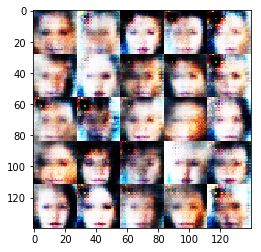

Epoch 1/1... Discriminator Loss: 0.4284... Generator Loss: 1.7006
Epoch 1/1... Discriminator Loss: 1.1491... Generator Loss: 2.4665
Epoch 1/1... Discriminator Loss: 1.5467... Generator Loss: 0.3012
Epoch 1/1... Discriminator Loss: 2.8467... Generator Loss: 0.0857
Epoch 1/1... Discriminator Loss: 0.3758... Generator Loss: 1.8094
Epoch 1/1... Discriminator Loss: 2.0611... Generator Loss: 0.1726
Epoch 1/1... Discriminator Loss: 1.2182... Generator Loss: 0.5376
Epoch 1/1... Discriminator Loss: 1.4827... Generator Loss: 1.3713
Epoch 1/1... Discriminator Loss: 0.8885... Generator Loss: 1.2283
Epoch 1/1... Discriminator Loss: 1.9314... Generator Loss: 0.2026


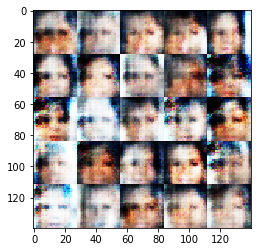

Epoch 1/1... Discriminator Loss: 1.2123... Generator Loss: 0.5105
Epoch 1/1... Discriminator Loss: 1.0407... Generator Loss: 0.6483
Epoch 1/1... Discriminator Loss: 1.1167... Generator Loss: 0.4623
Epoch 1/1... Discriminator Loss: 0.2356... Generator Loss: 3.9528
Epoch 1/1... Discriminator Loss: 1.5696... Generator Loss: 0.3891
Epoch 1/1... Discriminator Loss: 0.9639... Generator Loss: 2.6423
Epoch 1/1... Discriminator Loss: 0.2089... Generator Loss: 2.4823
Epoch 1/1... Discriminator Loss: 1.8487... Generator Loss: 1.6352
Epoch 1/1... Discriminator Loss: 0.9959... Generator Loss: 2.2167
Epoch 1/1... Discriminator Loss: 0.9662... Generator Loss: 0.7918


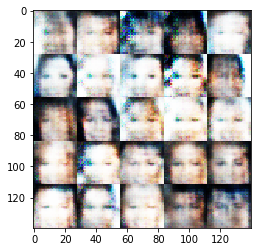

Epoch 1/1... Discriminator Loss: 1.8939... Generator Loss: 0.3106
Epoch 1/1... Discriminator Loss: 0.7097... Generator Loss: 1.6251
Epoch 1/1... Discriminator Loss: 1.6192... Generator Loss: 0.7636
Epoch 1/1... Discriminator Loss: 0.9237... Generator Loss: 1.1703
Epoch 1/1... Discriminator Loss: 1.0917... Generator Loss: 0.7578
Epoch 1/1... Discriminator Loss: 1.6371... Generator Loss: 1.5673
Epoch 1/1... Discriminator Loss: 1.5337... Generator Loss: 0.6290
Epoch 1/1... Discriminator Loss: 0.5921... Generator Loss: 1.6234
Epoch 1/1... Discriminator Loss: 0.8723... Generator Loss: 1.0094
Epoch 1/1... Discriminator Loss: 3.1257... Generator Loss: 0.3961


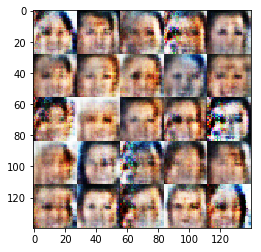

Epoch 1/1... Discriminator Loss: 1.6423... Generator Loss: 0.4633
Epoch 1/1... Discriminator Loss: 1.6607... Generator Loss: 0.4718
Epoch 1/1... Discriminator Loss: 1.5013... Generator Loss: 0.6483
Epoch 1/1... Discriminator Loss: 1.5722... Generator Loss: 0.6080
Epoch 1/1... Discriminator Loss: 1.5657... Generator Loss: 0.5071
Epoch 1/1... Discriminator Loss: 1.5595... Generator Loss: 0.5788
Epoch 1/1... Discriminator Loss: 1.8537... Generator Loss: 0.2729
Epoch 1/1... Discriminator Loss: 1.6652... Generator Loss: 0.4253
Epoch 1/1... Discriminator Loss: 1.5413... Generator Loss: 0.3999
Epoch 1/1... Discriminator Loss: 1.0007... Generator Loss: 0.6377


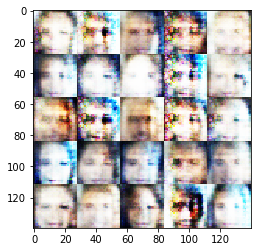

Epoch 1/1... Discriminator Loss: 1.6264... Generator Loss: 0.3082
Epoch 1/1... Discriminator Loss: 1.5167... Generator Loss: 0.5295
Epoch 1/1... Discriminator Loss: 1.0624... Generator Loss: 1.2683
Epoch 1/1... Discriminator Loss: 0.4734... Generator Loss: 1.7271
Epoch 1/1... Discriminator Loss: 1.6028... Generator Loss: 0.6751
Epoch 1/1... Discriminator Loss: 1.4905... Generator Loss: 0.6170
Epoch 1/1... Discriminator Loss: 1.7282... Generator Loss: 0.3876
Epoch 1/1... Discriminator Loss: 1.5662... Generator Loss: 0.5353
Epoch 1/1... Discriminator Loss: 1.3991... Generator Loss: 0.7031
Epoch 1/1... Discriminator Loss: 1.6412... Generator Loss: 0.3885


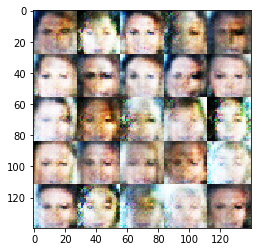

Epoch 1/1... Discriminator Loss: 1.4993... Generator Loss: 0.4741
Epoch 1/1... Discriminator Loss: 2.2666... Generator Loss: 0.2353
Epoch 1/1... Discriminator Loss: 1.5553... Generator Loss: 0.5252
Epoch 1/1... Discriminator Loss: 1.4801... Generator Loss: 0.6499
Epoch 1/1... Discriminator Loss: 1.7110... Generator Loss: 0.3902
Epoch 1/1... Discriminator Loss: 1.5575... Generator Loss: 0.4429
Epoch 1/1... Discriminator Loss: 1.4849... Generator Loss: 0.5963
Epoch 1/1... Discriminator Loss: 1.4603... Generator Loss: 0.6005
Epoch 1/1... Discriminator Loss: 1.7877... Generator Loss: 0.3808
Epoch 1/1... Discriminator Loss: 1.9003... Generator Loss: 0.4136


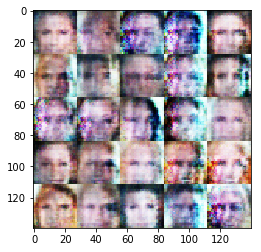

Epoch 1/1... Discriminator Loss: 1.7342... Generator Loss: 0.4561
Epoch 1/1... Discriminator Loss: 1.4735... Generator Loss: 0.6501
Epoch 1/1... Discriminator Loss: 1.7125... Generator Loss: 0.4434
Epoch 1/1... Discriminator Loss: 1.7800... Generator Loss: 0.3725
Epoch 1/1... Discriminator Loss: 2.1351... Generator Loss: 0.1671
Epoch 1/1... Discriminator Loss: 1.6763... Generator Loss: 0.4055
Epoch 1/1... Discriminator Loss: 1.5557... Generator Loss: 0.3601
Epoch 1/1... Discriminator Loss: 0.8735... Generator Loss: 1.4180
Epoch 1/1... Discriminator Loss: 1.9806... Generator Loss: 0.2318
Epoch 1/1... Discriminator Loss: 1.2126... Generator Loss: 0.5717


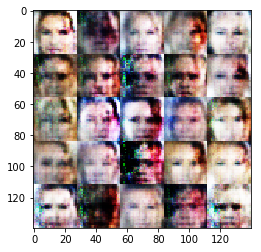

Epoch 1/1... Discriminator Loss: 1.0969... Generator Loss: 2.5271
Epoch 1/1... Discriminator Loss: 0.5449... Generator Loss: 2.0015
Epoch 1/1... Discriminator Loss: 1.9821... Generator Loss: 0.2686
Epoch 1/1... Discriminator Loss: 1.2029... Generator Loss: 0.7364
Epoch 1/1... Discriminator Loss: 1.7687... Generator Loss: 2.6748
Epoch 1/1... Discriminator Loss: 1.7143... Generator Loss: 0.4391
Epoch 1/1... Discriminator Loss: 1.7601... Generator Loss: 0.4133
Epoch 1/1... Discriminator Loss: 1.7694... Generator Loss: 0.4257
Epoch 1/1... Discriminator Loss: 1.6010... Generator Loss: 0.5052
Epoch 1/1... Discriminator Loss: 1.7787... Generator Loss: 0.3704


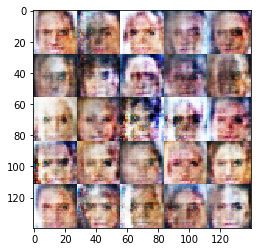

Epoch 1/1... Discriminator Loss: 0.9538... Generator Loss: 1.3161
Epoch 1/1... Discriminator Loss: 1.5254... Generator Loss: 0.4639
Epoch 1/1... Discriminator Loss: 0.7669... Generator Loss: 0.8876
Epoch 1/1... Discriminator Loss: 1.5900... Generator Loss: 0.4667
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.5701
Epoch 1/1... Discriminator Loss: 1.5264... Generator Loss: 0.5955
Epoch 1/1... Discriminator Loss: 1.9138... Generator Loss: 0.4726
Epoch 1/1... Discriminator Loss: 1.9252... Generator Loss: 0.6294
Epoch 1/1... Discriminator Loss: 0.6930... Generator Loss: 1.7956
Epoch 1/1... Discriminator Loss: 1.7219... Generator Loss: 0.3917


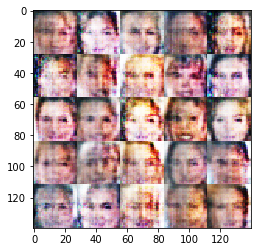

Epoch 1/1... Discriminator Loss: 1.3134... Generator Loss: 0.6323
Epoch 1/1... Discriminator Loss: 1.4457... Generator Loss: 0.9584
Epoch 1/1... Discriminator Loss: 1.4377... Generator Loss: 0.4119
Epoch 1/1... Discriminator Loss: 0.5607... Generator Loss: 2.3970
Epoch 1/1... Discriminator Loss: 0.8479... Generator Loss: 1.4219
Epoch 1/1... Discriminator Loss: 0.3732... Generator Loss: 1.8370
Epoch 1/1... Discriminator Loss: 1.8400... Generator Loss: 0.3595
Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.6097
Epoch 1/1... Discriminator Loss: 1.6545... Generator Loss: 0.4504
Epoch 1/1... Discriminator Loss: 1.6124... Generator Loss: 0.4813


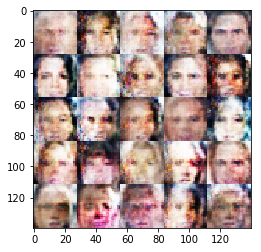

Epoch 1/1... Discriminator Loss: 1.7895... Generator Loss: 0.3273
Epoch 1/1... Discriminator Loss: 1.0817... Generator Loss: 0.6727
Epoch 1/1... Discriminator Loss: 1.2273... Generator Loss: 1.5390
Epoch 1/1... Discriminator Loss: 2.1364... Generator Loss: 0.1730
Epoch 1/1... Discriminator Loss: 1.6226... Generator Loss: 0.4512
Epoch 1/1... Discriminator Loss: 1.5787... Generator Loss: 0.5463
Epoch 1/1... Discriminator Loss: 1.6651... Generator Loss: 0.7026
Epoch 1/1... Discriminator Loss: 2.2780... Generator Loss: 2.0870
Epoch 1/1... Discriminator Loss: 1.5338... Generator Loss: 0.5461
Epoch 1/1... Discriminator Loss: 1.8048... Generator Loss: 0.3886


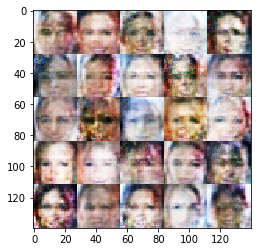

Epoch 1/1... Discriminator Loss: 1.8829... Generator Loss: 0.2758
Epoch 1/1... Discriminator Loss: 1.8335... Generator Loss: 0.3532
Epoch 1/1... Discriminator Loss: 1.5692... Generator Loss: 0.3226
Epoch 1/1... Discriminator Loss: 1.1610... Generator Loss: 0.5102
Epoch 1/1... Discriminator Loss: 1.7433... Generator Loss: 0.6756
Epoch 1/1... Discriminator Loss: 0.8646... Generator Loss: 1.2441
Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.3892
Epoch 1/1... Discriminator Loss: 1.7543... Generator Loss: 0.3249
Epoch 1/1... Discriminator Loss: 1.5334... Generator Loss: 0.4721
Epoch 1/1... Discriminator Loss: 1.5831... Generator Loss: 0.7794


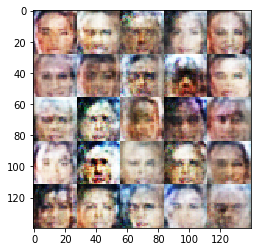

Epoch 1/1... Discriminator Loss: 1.2225... Generator Loss: 0.7057
Epoch 1/1... Discriminator Loss: 2.0233... Generator Loss: 0.2139
Epoch 1/1... Discriminator Loss: 1.5274... Generator Loss: 0.5626
Epoch 1/1... Discriminator Loss: 1.8437... Generator Loss: 0.2417
Epoch 1/1... Discriminator Loss: 1.6834... Generator Loss: 0.4034
Epoch 1/1... Discriminator Loss: 1.7395... Generator Loss: 0.4718
Epoch 1/1... Discriminator Loss: 1.9094... Generator Loss: 0.2780
Epoch 1/1... Discriminator Loss: 2.0350... Generator Loss: 0.2225
Epoch 1/1... Discriminator Loss: 1.8108... Generator Loss: 0.4073
Epoch 1/1... Discriminator Loss: 1.2847... Generator Loss: 0.7549


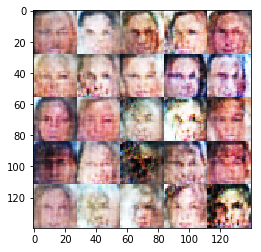

Epoch 1/1... Discriminator Loss: 1.3198... Generator Loss: 0.5454
Epoch 1/1... Discriminator Loss: 1.0579... Generator Loss: 0.6941
Epoch 1/1... Discriminator Loss: 1.8619... Generator Loss: 0.2264
Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 0.8572
Epoch 1/1... Discriminator Loss: 1.2244... Generator Loss: 0.6693
Epoch 1/1... Discriminator Loss: 1.7146... Generator Loss: 0.4232
Epoch 1/1... Discriminator Loss: 1.3524... Generator Loss: 0.3973
Epoch 1/1... Discriminator Loss: 1.6424... Generator Loss: 0.4601
Epoch 1/1... Discriminator Loss: 1.9521... Generator Loss: 0.2440
Epoch 1/1... Discriminator Loss: 1.9588... Generator Loss: 0.1756


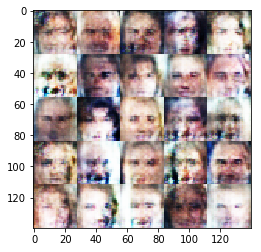

Epoch 1/1... Discriminator Loss: 1.4858... Generator Loss: 0.9090
Epoch 1/1... Discriminator Loss: 1.8232... Generator Loss: 0.2544
Epoch 1/1... Discriminator Loss: 1.6431... Generator Loss: 0.4844
Epoch 1/1... Discriminator Loss: 0.7835... Generator Loss: 0.8759
Epoch 1/1... Discriminator Loss: 1.7465... Generator Loss: 0.4753
Epoch 1/1... Discriminator Loss: 1.6445... Generator Loss: 0.5215
Epoch 1/1... Discriminator Loss: 1.9812... Generator Loss: 0.2359
Epoch 1/1... Discriminator Loss: 1.5758... Generator Loss: 0.4477
Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.5681
Epoch 1/1... Discriminator Loss: 1.5274... Generator Loss: 0.6556


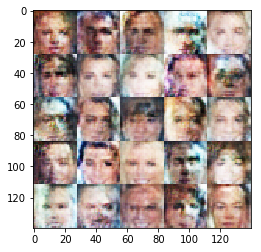

Epoch 1/1... Discriminator Loss: 1.5284... Generator Loss: 0.4518
Epoch 1/1... Discriminator Loss: 1.4980... Generator Loss: 0.4710
Epoch 1/1... Discriminator Loss: 1.9670... Generator Loss: 0.2174
Epoch 1/1... Discriminator Loss: 1.7296... Generator Loss: 0.3283
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.6415
Epoch 1/1... Discriminator Loss: 2.0279... Generator Loss: 0.2429
Epoch 1/1... Discriminator Loss: 1.7569... Generator Loss: 0.3231
Epoch 1/1... Discriminator Loss: 1.9505... Generator Loss: 0.3624
Epoch 1/1... Discriminator Loss: 1.5630... Generator Loss: 0.3377
Epoch 1/1... Discriminator Loss: 1.8944... Generator Loss: 0.2283


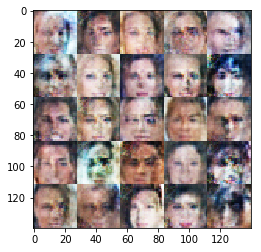

Epoch 1/1... Discriminator Loss: 1.6752... Generator Loss: 0.4584
Epoch 1/1... Discriminator Loss: 1.6865... Generator Loss: 0.3933
Epoch 1/1... Discriminator Loss: 1.5667... Generator Loss: 0.4432
Epoch 1/1... Discriminator Loss: 1.7861... Generator Loss: 0.4385
Epoch 1/1... Discriminator Loss: 1.6827... Generator Loss: 0.5283
Epoch 1/1... Discriminator Loss: 2.0195... Generator Loss: 0.2243
Epoch 1/1... Discriminator Loss: 1.8850... Generator Loss: 0.2710
Epoch 1/1... Discriminator Loss: 1.8957... Generator Loss: 0.2637
Epoch 1/1... Discriminator Loss: 2.3503... Generator Loss: 0.1327
Epoch 1/1... Discriminator Loss: 2.0948... Generator Loss: 0.2537


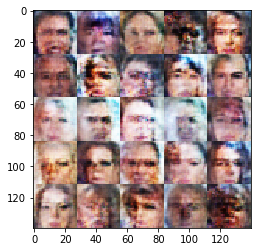

Epoch 1/1... Discriminator Loss: 1.8996... Generator Loss: 0.3461
Epoch 1/1... Discriminator Loss: 1.6807... Generator Loss: 0.5761
Epoch 1/1... Discriminator Loss: 1.1489... Generator Loss: 0.6220
Epoch 1/1... Discriminator Loss: 1.7661... Generator Loss: 0.3795
Epoch 1/1... Discriminator Loss: 1.6128... Generator Loss: 0.4411
Epoch 1/1... Discriminator Loss: 1.9244... Generator Loss: 0.3126
Epoch 1/1... Discriminator Loss: 1.9511... Generator Loss: 0.2422
Epoch 1/1... Discriminator Loss: 1.7014... Generator Loss: 0.3983
Epoch 1/1... Discriminator Loss: 1.8538... Generator Loss: 0.2788
Epoch 1/1... Discriminator Loss: 1.9838... Generator Loss: 0.2369


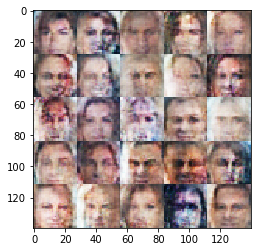

Epoch 1/1... Discriminator Loss: 1.7967... Generator Loss: 0.3028
Epoch 1/1... Discriminator Loss: 1.6598... Generator Loss: 0.3868
Epoch 1/1... Discriminator Loss: 1.9089... Generator Loss: 0.2616
Epoch 1/1... Discriminator Loss: 1.8814... Generator Loss: 0.2773
Epoch 1/1... Discriminator Loss: 1.8951... Generator Loss: 0.2257
Epoch 1/1... Discriminator Loss: 1.8275... Generator Loss: 0.2552
Epoch 1/1... Discriminator Loss: 1.9754... Generator Loss: 0.3172
Epoch 1/1... Discriminator Loss: 1.9662... Generator Loss: 0.2842
Epoch 1/1... Discriminator Loss: 1.7667... Generator Loss: 0.4229
Epoch 1/1... Discriminator Loss: 1.6566... Generator Loss: 0.4247


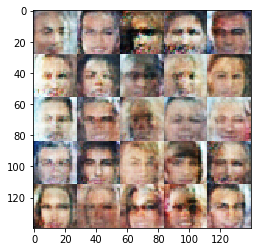

Epoch 1/1... Discriminator Loss: 1.9651... Generator Loss: 0.2347
Epoch 1/1... Discriminator Loss: 2.0997... Generator Loss: 0.2036
Epoch 1/1... Discriminator Loss: 2.2215... Generator Loss: 0.1359
Epoch 1/1... Discriminator Loss: 1.9478... Generator Loss: 0.4430
Epoch 1/1... Discriminator Loss: 1.4517... Generator Loss: 0.4954
Epoch 1/1... Discriminator Loss: 1.7859... Generator Loss: 0.3762
Epoch 1/1... Discriminator Loss: 2.1086... Generator Loss: 0.1659
Epoch 1/1... Discriminator Loss: 1.4761... Generator Loss: 0.5157
Epoch 1/1... Discriminator Loss: 2.0872... Generator Loss: 0.1882
Epoch 1/1... Discriminator Loss: 1.7391... Generator Loss: 0.3649


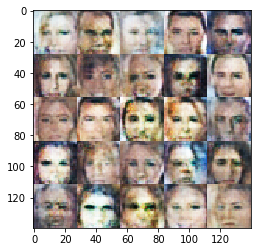

Epoch 1/1... Discriminator Loss: 1.5759... Generator Loss: 0.3918
Epoch 1/1... Discriminator Loss: 1.7133... Generator Loss: 0.2968
Epoch 1/1... Discriminator Loss: 1.5597... Generator Loss: 0.4018
Epoch 1/1... Discriminator Loss: 1.9079... Generator Loss: 0.3904
Epoch 1/1... Discriminator Loss: 1.8820... Generator Loss: 0.2300
Epoch 1/1... Discriminator Loss: 1.7243... Generator Loss: 0.3379
Epoch 1/1... Discriminator Loss: 1.6747... Generator Loss: 0.3174
Epoch 1/1... Discriminator Loss: 1.8271... Generator Loss: 0.3848
Epoch 1/1... Discriminator Loss: 1.7748... Generator Loss: 0.4483
Epoch 1/1... Discriminator Loss: 1.5009... Generator Loss: 0.5899


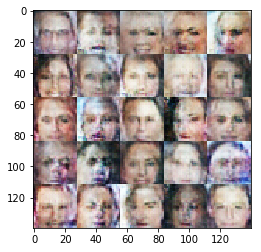

Epoch 1/1... Discriminator Loss: 1.7701... Generator Loss: 0.5125
Epoch 1/1... Discriminator Loss: 1.9909... Generator Loss: 0.2011
Epoch 1/1... Discriminator Loss: 1.9566... Generator Loss: 0.2056
Epoch 1/1... Discriminator Loss: 1.8465... Generator Loss: 0.4041
Epoch 1/1... Discriminator Loss: 1.9151... Generator Loss: 0.2780
Epoch 1/1... Discriminator Loss: 1.7416... Generator Loss: 0.3190
Epoch 1/1... Discriminator Loss: 2.1975... Generator Loss: 0.3621
Epoch 1/1... Discriminator Loss: 1.9594... Generator Loss: 0.2601
Epoch 1/1... Discriminator Loss: 1.8555... Generator Loss: 0.2915
Epoch 1/1... Discriminator Loss: 1.7446... Generator Loss: 0.3474


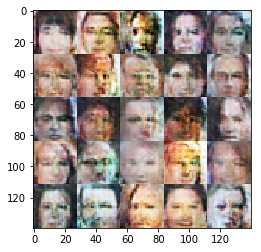

Epoch 1/1... Discriminator Loss: 1.7641... Generator Loss: 0.3598
Epoch 1/1... Discriminator Loss: 1.5912... Generator Loss: 0.4844
Epoch 1/1... Discriminator Loss: 1.7238... Generator Loss: 0.3759
Epoch 1/1... Discriminator Loss: 1.9247... Generator Loss: 0.2988
Epoch 1/1... Discriminator Loss: 2.2213... Generator Loss: 0.1730
Epoch 1/1... Discriminator Loss: 1.6938... Generator Loss: 0.3998
Epoch 1/1... Discriminator Loss: 2.1646... Generator Loss: 0.1842
Epoch 1/1... Discriminator Loss: 2.2340... Generator Loss: 0.1341
Epoch 1/1... Discriminator Loss: 1.8096... Generator Loss: 0.3386
Epoch 1/1... Discriminator Loss: 1.6087... Generator Loss: 0.5621


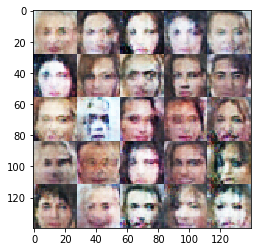

Epoch 1/1... Discriminator Loss: 1.2492... Generator Loss: 1.1754
Epoch 1/1... Discriminator Loss: 1.7023... Generator Loss: 0.7536
Epoch 1/1... Discriminator Loss: 1.5461... Generator Loss: 0.4288
Epoch 1/1... Discriminator Loss: 1.8506... Generator Loss: 0.2222
Epoch 1/1... Discriminator Loss: 2.0758... Generator Loss: 0.2247
Epoch 1/1... Discriminator Loss: 1.8883... Generator Loss: 0.3132
Epoch 1/1... Discriminator Loss: 2.1378... Generator Loss: 0.1987
Epoch 1/1... Discriminator Loss: 2.1998... Generator Loss: 0.1497
Epoch 1/1... Discriminator Loss: 2.1138... Generator Loss: 0.1798
Epoch 1/1... Discriminator Loss: 2.1226... Generator Loss: 0.1994


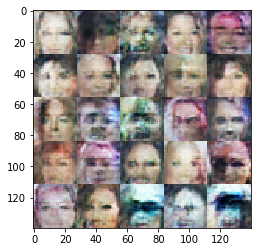

Epoch 1/1... Discriminator Loss: 2.1899... Generator Loss: 0.2152
Epoch 1/1... Discriminator Loss: 2.0328... Generator Loss: 0.1877
Epoch 1/1... Discriminator Loss: 2.3871... Generator Loss: 0.1275
Epoch 1/1... Discriminator Loss: 1.7746... Generator Loss: 0.4135
Epoch 1/1... Discriminator Loss: 1.9636... Generator Loss: 0.2024
Epoch 1/1... Discriminator Loss: 2.0274... Generator Loss: 0.2457
Epoch 1/1... Discriminator Loss: 1.8740... Generator Loss: 0.3611
Epoch 1/1... Discriminator Loss: 1.6575... Generator Loss: 0.4369
Epoch 1/1... Discriminator Loss: 2.0534... Generator Loss: 0.2254
Epoch 1/1... Discriminator Loss: 2.2765... Generator Loss: 0.1397


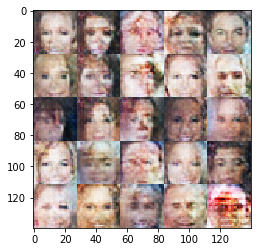

Epoch 1/1... Discriminator Loss: 2.0321... Generator Loss: 0.1899
Epoch 1/1... Discriminator Loss: 2.4778... Generator Loss: 0.1185
Epoch 1/1... Discriminator Loss: 2.0355... Generator Loss: 0.2007
Epoch 1/1... Discriminator Loss: 1.6231... Generator Loss: 0.4814
Epoch 1/1... Discriminator Loss: 2.0131... Generator Loss: 0.2399
Epoch 1/1... Discriminator Loss: 1.7089... Generator Loss: 0.3670
Epoch 1/1... Discriminator Loss: 2.2342... Generator Loss: 0.3074
Epoch 1/1... Discriminator Loss: 1.7133... Generator Loss: 0.3547
Epoch 1/1... Discriminator Loss: 2.2881... Generator Loss: 0.1746
Epoch 1/1... Discriminator Loss: 2.0399... Generator Loss: 0.1953


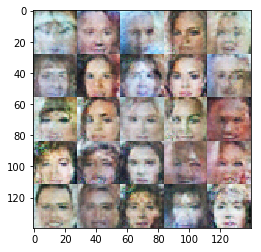

Epoch 1/1... Discriminator Loss: 2.1003... Generator Loss: 0.1989
Epoch 1/1... Discriminator Loss: 1.8924... Generator Loss: 0.2340
Epoch 1/1... Discriminator Loss: 1.9485... Generator Loss: 0.2208
Epoch 1/1... Discriminator Loss: 1.7669... Generator Loss: 0.4883
Epoch 1/1... Discriminator Loss: 1.8348... Generator Loss: 0.2612
Epoch 1/1... Discriminator Loss: 1.8427... Generator Loss: 0.3085
Epoch 1/1... Discriminator Loss: 1.9151... Generator Loss: 0.7368
Epoch 1/1... Discriminator Loss: 1.9281... Generator Loss: 0.2392
Epoch 1/1... Discriminator Loss: 1.9087... Generator Loss: 0.2398
Epoch 1/1... Discriminator Loss: 2.0542... Generator Loss: 0.2422


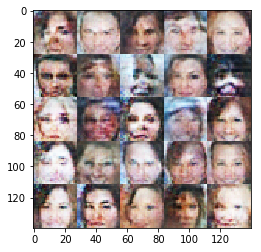

Epoch 1/1... Discriminator Loss: 1.9735... Generator Loss: 0.2638
Epoch 1/1... Discriminator Loss: 2.5192... Generator Loss: 0.1118
Epoch 1/1... Discriminator Loss: 1.8524... Generator Loss: 0.2959
Epoch 1/1... Discriminator Loss: 1.8085... Generator Loss: 0.3319
Epoch 1/1... Discriminator Loss: 1.8352... Generator Loss: 0.3018
Epoch 1/1... Discriminator Loss: 1.9391... Generator Loss: 0.3413
Epoch 1/1... Discriminator Loss: 1.1656... Generator Loss: 0.6724
Epoch 1/1... Discriminator Loss: 1.9106... Generator Loss: 0.3340
Epoch 1/1... Discriminator Loss: 1.3087... Generator Loss: 0.8278
Epoch 1/1... Discriminator Loss: 1.9013... Generator Loss: 0.3529


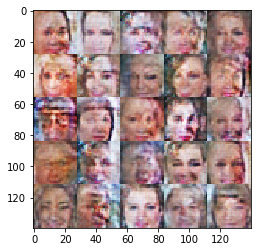

Epoch 1/1... Discriminator Loss: 1.6814... Generator Loss: 0.3685
Epoch 1/1... Discriminator Loss: 2.0983... Generator Loss: 0.2245
Epoch 1/1... Discriminator Loss: 1.8987... Generator Loss: 0.2749
Epoch 1/1... Discriminator Loss: 1.8889... Generator Loss: 0.2621
Epoch 1/1... Discriminator Loss: 1.9635... Generator Loss: 0.2839
Epoch 1/1... Discriminator Loss: 1.4336... Generator Loss: 0.6610
Epoch 1/1... Discriminator Loss: 1.9781... Generator Loss: 0.2050
Epoch 1/1... Discriminator Loss: 2.0392... Generator Loss: 0.2233
Epoch 1/1... Discriminator Loss: 1.6503... Generator Loss: 0.5946
Epoch 1/1... Discriminator Loss: 1.9900... Generator Loss: 0.2070


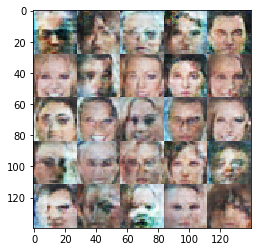

Epoch 1/1... Discriminator Loss: 2.0099... Generator Loss: 0.1889
Epoch 1/1... Discriminator Loss: 1.8333... Generator Loss: 0.2302
Epoch 1/1... Discriminator Loss: 1.8601... Generator Loss: 0.2924
Epoch 1/1... Discriminator Loss: 1.8362... Generator Loss: 0.2688
Epoch 1/1... Discriminator Loss: 2.0671... Generator Loss: 0.3471
Epoch 1/1... Discriminator Loss: 2.0586... Generator Loss: 0.1883
Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.6596
Epoch 1/1... Discriminator Loss: 2.2900... Generator Loss: 0.1465
Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 0.5905
Epoch 1/1... Discriminator Loss: 2.0659... Generator Loss: 0.1849


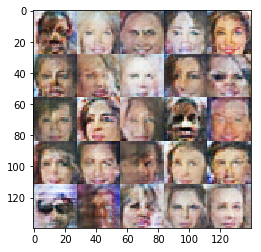

Epoch 1/1... Discriminator Loss: 2.2036... Generator Loss: 0.1548
Epoch 1/1... Discriminator Loss: 1.8667... Generator Loss: 0.3381
Epoch 1/1... Discriminator Loss: 1.3523... Generator Loss: 0.7068
Epoch 1/1... Discriminator Loss: 2.1239... Generator Loss: 0.1585
Epoch 1/1... Discriminator Loss: 2.0630... Generator Loss: 0.2090
Epoch 1/1... Discriminator Loss: 1.8098... Generator Loss: 0.2832
Epoch 1/1... Discriminator Loss: 1.9282... Generator Loss: 0.3176
Epoch 1/1... Discriminator Loss: 2.0731... Generator Loss: 0.1888
Epoch 1/1... Discriminator Loss: 2.0513... Generator Loss: 0.6075
Epoch 1/1... Discriminator Loss: 1.7926... Generator Loss: 0.5514


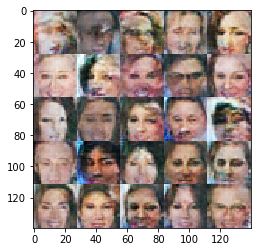

Epoch 1/1... Discriminator Loss: 2.2589... Generator Loss: 0.1509
Epoch 1/1... Discriminator Loss: 2.3046... Generator Loss: 0.1497
Epoch 1/1... Discriminator Loss: 1.8976... Generator Loss: 0.2399
Epoch 1/1... Discriminator Loss: 2.1008... Generator Loss: 0.1824
Epoch 1/1... Discriminator Loss: 1.4636... Generator Loss: 0.5515
Epoch 1/1... Discriminator Loss: 2.2074... Generator Loss: 0.1553
Epoch 1/1... Discriminator Loss: 2.2312... Generator Loss: 0.1645
Epoch 1/1... Discriminator Loss: 1.8814... Generator Loss: 0.2365
Epoch 1/1... Discriminator Loss: 1.9090... Generator Loss: 0.4731
Epoch 1/1... Discriminator Loss: 1.7458... Generator Loss: 0.3488


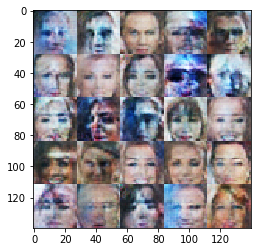

Epoch 1/1... Discriminator Loss: 2.4567... Generator Loss: 0.1328
Epoch 1/1... Discriminator Loss: 1.9810... Generator Loss: 0.2058
Epoch 1/1... Discriminator Loss: 1.5837... Generator Loss: 0.2678
Epoch 1/1... Discriminator Loss: 2.2200... Generator Loss: 0.2879
Epoch 1/1... Discriminator Loss: 1.9917... Generator Loss: 2.3465
Epoch 1/1... Discriminator Loss: 1.8192... Generator Loss: 0.2427
Epoch 1/1... Discriminator Loss: 0.6013... Generator Loss: 6.8393
Epoch 1/1... Discriminator Loss: 1.9503... Generator Loss: 0.3530
Epoch 1/1... Discriminator Loss: 1.8331... Generator Loss: 0.2648
Epoch 1/1... Discriminator Loss: 1.7695... Generator Loss: 0.3285


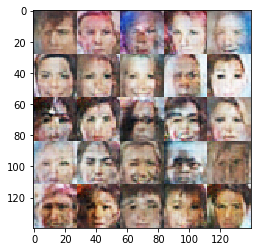

Epoch 1/1... Discriminator Loss: 2.0985... Generator Loss: 0.1611
Epoch 1/1... Discriminator Loss: 1.9996... Generator Loss: 0.1997
Epoch 1/1... Discriminator Loss: 1.8408... Generator Loss: 0.3282
Epoch 1/1... Discriminator Loss: 2.2563... Generator Loss: 0.5089
Epoch 1/1... Discriminator Loss: 1.5562... Generator Loss: 0.4873
Epoch 1/1... Discriminator Loss: 1.8677... Generator Loss: 0.2635
Epoch 1/1... Discriminator Loss: 2.1507... Generator Loss: 0.2087
Epoch 1/1... Discriminator Loss: 2.1499... Generator Loss: 0.1705
Epoch 1/1... Discriminator Loss: 1.9428... Generator Loss: 0.2312
Epoch 1/1... Discriminator Loss: 1.0932... Generator Loss: 1.4527


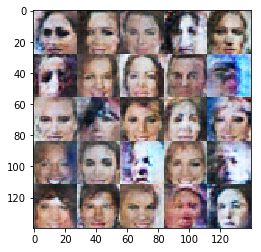

Epoch 1/1... Discriminator Loss: 2.1077... Generator Loss: 0.3326
Epoch 1/1... Discriminator Loss: 2.5351... Generator Loss: 0.1031
Epoch 1/1... Discriminator Loss: 1.8773... Generator Loss: 0.2290
Epoch 1/1... Discriminator Loss: 1.9798... Generator Loss: 0.3336
Epoch 1/1... Discriminator Loss: 1.8291... Generator Loss: 0.3082
Epoch 1/1... Discriminator Loss: 1.8498... Generator Loss: 0.2662
Epoch 1/1... Discriminator Loss: 2.0292... Generator Loss: 0.2128
Epoch 1/1... Discriminator Loss: 2.1857... Generator Loss: 0.1504
Epoch 1/1... Discriminator Loss: 2.0850... Generator Loss: 0.2098
Epoch 1/1... Discriminator Loss: 1.8608... Generator Loss: 0.4716


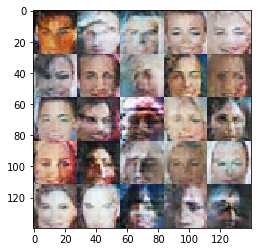

Epoch 1/1... Discriminator Loss: 1.8840... Generator Loss: 0.3018
Epoch 1/1... Discriminator Loss: 2.1673... Generator Loss: 0.1647
Epoch 1/1... Discriminator Loss: 2.0360... Generator Loss: 0.2169
Epoch 1/1... Discriminator Loss: 2.0906... Generator Loss: 0.1730
Epoch 1/1... Discriminator Loss: 1.9419... Generator Loss: 0.1964
Epoch 1/1... Discriminator Loss: 1.8920... Generator Loss: 0.2534
Epoch 1/1... Discriminator Loss: 2.0647... Generator Loss: 0.3205
Epoch 1/1... Discriminator Loss: 1.8157... Generator Loss: 0.2747
Epoch 1/1... Discriminator Loss: 2.0703... Generator Loss: 0.1941
Epoch 1/1... Discriminator Loss: 2.5464... Generator Loss: 0.1094


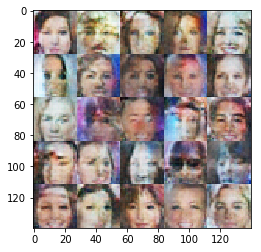

Epoch 1/1... Discriminator Loss: 1.6841... Generator Loss: 0.5010
Epoch 1/1... Discriminator Loss: 1.9489... Generator Loss: 0.2116
Epoch 1/1... Discriminator Loss: 1.8333... Generator Loss: 0.3075
Epoch 1/1... Discriminator Loss: 1.6523... Generator Loss: 0.3474
Epoch 1/1... Discriminator Loss: 2.4451... Generator Loss: 0.1241
Epoch 1/1... Discriminator Loss: 1.8854... Generator Loss: 0.2647
Epoch 1/1... Discriminator Loss: 1.9342... Generator Loss: 0.2677
Epoch 1/1... Discriminator Loss: 1.7575... Generator Loss: 0.3758
Epoch 1/1... Discriminator Loss: 1.8255... Generator Loss: 1.0103
Epoch 1/1... Discriminator Loss: 2.1084... Generator Loss: 0.1737


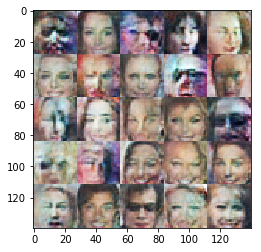

Epoch 1/1... Discriminator Loss: 1.7451... Generator Loss: 0.3861
Epoch 1/1... Discriminator Loss: 2.0968... Generator Loss: 0.2449
Epoch 1/1... Discriminator Loss: 1.8594... Generator Loss: 0.3354
Epoch 1/1... Discriminator Loss: 1.8128... Generator Loss: 0.3307
Epoch 1/1... Discriminator Loss: 1.3689... Generator Loss: 0.4750
Epoch 1/1... Discriminator Loss: 1.7043... Generator Loss: 0.4312
Epoch 1/1... Discriminator Loss: 2.1040... Generator Loss: 0.1694
Epoch 1/1... Discriminator Loss: 1.9796... Generator Loss: 0.2185
Epoch 1/1... Discriminator Loss: 2.1944... Generator Loss: 0.1622
Epoch 1/1... Discriminator Loss: 1.6866... Generator Loss: 0.4341


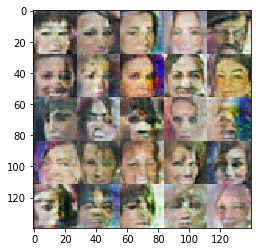

Epoch 1/1... Discriminator Loss: 2.9696... Generator Loss: 0.6024
Epoch 1/1... Discriminator Loss: 2.1356... Generator Loss: 0.1984
Epoch 1/1... Discriminator Loss: 2.1867... Generator Loss: 0.2348
Epoch 1/1... Discriminator Loss: 2.2549... Generator Loss: 0.1721
Epoch 1/1... Discriminator Loss: 1.6430... Generator Loss: 0.3314
Epoch 1/1... Discriminator Loss: 2.0621... Generator Loss: 0.2242
Epoch 1/1... Discriminator Loss: 2.4287... Generator Loss: 0.1260
Epoch 1/1... Discriminator Loss: 2.1550... Generator Loss: 0.1802
Epoch 1/1... Discriminator Loss: 2.1496... Generator Loss: 0.2098
Epoch 1/1... Discriminator Loss: 2.2282... Generator Loss: 0.1446


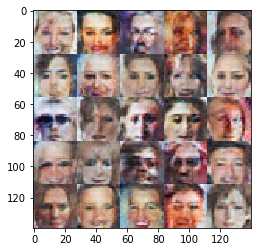

Epoch 1/1... Discriminator Loss: 1.9395... Generator Loss: 0.2162
Epoch 1/1... Discriminator Loss: 2.0599... Generator Loss: 0.2529
Epoch 1/1... Discriminator Loss: 2.1162... Generator Loss: 0.1560
Epoch 1/1... Discriminator Loss: 1.9991... Generator Loss: 0.2497
Epoch 1/1... Discriminator Loss: 2.0952... Generator Loss: 0.2134
Epoch 1/1... Discriminator Loss: 2.1898... Generator Loss: 0.4924
Epoch 1/1... Discriminator Loss: 2.0943... Generator Loss: 0.1598
Epoch 1/1... Discriminator Loss: 1.7160... Generator Loss: 0.4658
Epoch 1/1... Discriminator Loss: 2.3339... Generator Loss: 0.1397
Epoch 1/1... Discriminator Loss: 1.8856... Generator Loss: 0.3635


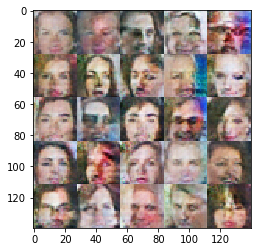

Epoch 1/1... Discriminator Loss: 2.1722... Generator Loss: 0.1501
Epoch 1/1... Discriminator Loss: 1.7886... Generator Loss: 0.2594
Epoch 1/1... Discriminator Loss: 2.0785... Generator Loss: 0.2189
Epoch 1/1... Discriminator Loss: 1.8413... Generator Loss: 0.3764
Epoch 1/1... Discriminator Loss: 1.8795... Generator Loss: 0.3229
Epoch 1/1... Discriminator Loss: 2.0538... Generator Loss: 0.2747
Epoch 1/1... Discriminator Loss: 1.8374... Generator Loss: 0.2871
Epoch 1/1... Discriminator Loss: 2.0375... Generator Loss: 0.6503
Epoch 1/1... Discriminator Loss: 2.0075... Generator Loss: 0.2955
Epoch 1/1... Discriminator Loss: 1.9619... Generator Loss: 0.2340


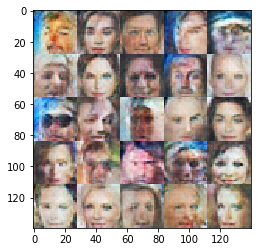

Epoch 1/1... Discriminator Loss: 1.6605... Generator Loss: 0.4524
Epoch 1/1... Discriminator Loss: 1.9317... Generator Loss: 0.2715
Epoch 1/1... Discriminator Loss: 2.4238... Generator Loss: 0.1533
Epoch 1/1... Discriminator Loss: 2.3924... Generator Loss: 0.1295
Epoch 1/1... Discriminator Loss: 2.1909... Generator Loss: 0.1925
Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 0.5474
Epoch 1/1... Discriminator Loss: 1.9937... Generator Loss: 0.2248
Epoch 1/1... Discriminator Loss: 2.0889... Generator Loss: 0.2713
Epoch 1/1... Discriminator Loss: 2.9481... Generator Loss: 0.0626
Epoch 1/1... Discriminator Loss: 2.1988... Generator Loss: 0.1729


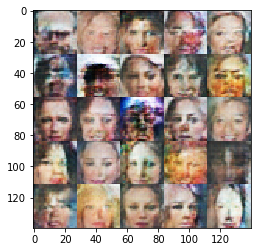

Epoch 1/1... Discriminator Loss: 1.9829... Generator Loss: 0.1825
Epoch 1/1... Discriminator Loss: 2.2977... Generator Loss: 0.1362
Epoch 1/1... Discriminator Loss: 1.9101... Generator Loss: 0.2407
Epoch 1/1... Discriminator Loss: 2.0974... Generator Loss: 0.2133
Epoch 1/1... Discriminator Loss: 1.7252... Generator Loss: 0.3229
Epoch 1/1... Discriminator Loss: 1.8474... Generator Loss: 0.2960
Epoch 1/1... Discriminator Loss: 1.8708... Generator Loss: 0.3913
Epoch 1/1... Discriminator Loss: 1.8610... Generator Loss: 0.2735
Epoch 1/1... Discriminator Loss: 1.7255... Generator Loss: 0.4204
Epoch 1/1... Discriminator Loss: 1.7904... Generator Loss: 0.3371


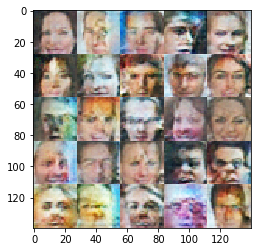

Epoch 1/1... Discriminator Loss: 1.9984... Generator Loss: 0.2139
Epoch 1/1... Discriminator Loss: 2.5482... Generator Loss: 0.1070
Epoch 1/1... Discriminator Loss: 2.0026... Generator Loss: 0.2250
Epoch 1/1... Discriminator Loss: 1.8980... Generator Loss: 0.4266
Epoch 1/1... Discriminator Loss: 2.2814... Generator Loss: 0.1449
Epoch 1/1... Discriminator Loss: 2.1265... Generator Loss: 0.3601
Epoch 1/1... Discriminator Loss: 1.9433... Generator Loss: 0.2457
Epoch 1/1... Discriminator Loss: 1.8974... Generator Loss: 0.2524
Epoch 1/1... Discriminator Loss: 1.8335... Generator Loss: 0.2982
Epoch 1/1... Discriminator Loss: 2.3292... Generator Loss: 0.1433


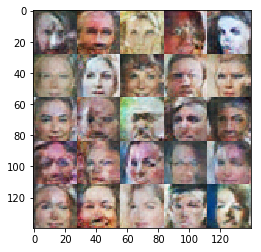

Epoch 1/1... Discriminator Loss: 2.5157... Generator Loss: 0.1266
Epoch 1/1... Discriminator Loss: 2.1426... Generator Loss: 0.4743
Epoch 1/1... Discriminator Loss: 2.2865... Generator Loss: 0.1512
Epoch 1/1... Discriminator Loss: 1.9478... Generator Loss: 0.3778
Epoch 1/1... Discriminator Loss: 1.9315... Generator Loss: 0.3165
Epoch 1/1... Discriminator Loss: 2.2989... Generator Loss: 0.1653
Epoch 1/1... Discriminator Loss: 1.9035... Generator Loss: 0.2692
Epoch 1/1... Discriminator Loss: 2.1022... Generator Loss: 0.2044
Epoch 1/1... Discriminator Loss: 1.7980... Generator Loss: 0.5827
Epoch 1/1... Discriminator Loss: 2.0777... Generator Loss: 0.2874


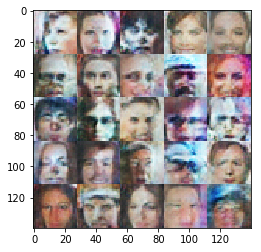

Epoch 1/1... Discriminator Loss: 1.9471... Generator Loss: 0.2741
Epoch 1/1... Discriminator Loss: 2.3529... Generator Loss: 0.1372
Epoch 1/1... Discriminator Loss: 2.1717... Generator Loss: 0.1678
Epoch 1/1... Discriminator Loss: 1.8040... Generator Loss: 0.3682
Epoch 1/1... Discriminator Loss: 2.0255... Generator Loss: 0.2026
Epoch 1/1... Discriminator Loss: 1.8238... Generator Loss: 0.2836
Epoch 1/1... Discriminator Loss: 1.8489... Generator Loss: 0.3305
Epoch 1/1... Discriminator Loss: 2.4537... Generator Loss: 0.1102
Epoch 1/1... Discriminator Loss: 2.2562... Generator Loss: 0.1640
Epoch 1/1... Discriminator Loss: 2.3163... Generator Loss: 0.2343


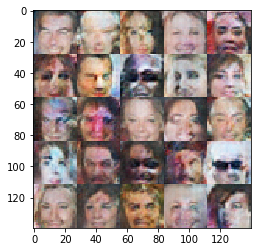

Epoch 1/1... Discriminator Loss: 2.5576... Generator Loss: 0.0949
Epoch 1/1... Discriminator Loss: 2.1562... Generator Loss: 0.1471
Epoch 1/1... Discriminator Loss: 1.9006... Generator Loss: 0.2755
Epoch 1/1... Discriminator Loss: 2.3957... Generator Loss: 0.1314
Epoch 1/1... Discriminator Loss: 1.6975... Generator Loss: 0.3554
Epoch 1/1... Discriminator Loss: 1.8163... Generator Loss: 0.3354
Epoch 1/1... Discriminator Loss: 1.7921... Generator Loss: 0.3243
Epoch 1/1... Discriminator Loss: 1.8417... Generator Loss: 0.3306
Epoch 1/1... Discriminator Loss: 1.7143... Generator Loss: 0.3726
Epoch 1/1... Discriminator Loss: 2.0499... Generator Loss: 0.1907


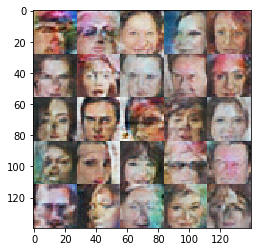

Epoch 1/1... Discriminator Loss: 1.9905... Generator Loss: 0.2909
Epoch 1/1... Discriminator Loss: 1.9428... Generator Loss: 0.2230
Epoch 1/1... Discriminator Loss: 2.5118... Generator Loss: 0.1136
Epoch 1/1... Discriminator Loss: 1.5883... Generator Loss: 0.7316
Epoch 1/1... Discriminator Loss: 1.8378... Generator Loss: 0.3350
Epoch 1/1... Discriminator Loss: 2.1416... Generator Loss: 0.1679
Epoch 1/1... Discriminator Loss: 1.9421... Generator Loss: 0.2771
Epoch 1/1... Discriminator Loss: 2.1759... Generator Loss: 0.2506
Epoch 1/1... Discriminator Loss: 2.0364... Generator Loss: 0.2232
Epoch 1/1... Discriminator Loss: 1.9905... Generator Loss: 0.2681


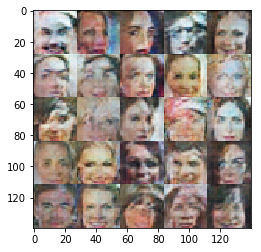

Epoch 1/1... Discriminator Loss: 2.3453... Generator Loss: 0.1311
Epoch 1/1... Discriminator Loss: 1.7805... Generator Loss: 0.3132
Epoch 1/1... Discriminator Loss: 2.2314... Generator Loss: 0.1591
Epoch 1/1... Discriminator Loss: 2.3790... Generator Loss: 0.1307
Epoch 1/1... Discriminator Loss: 1.9436... Generator Loss: 0.1842
Epoch 1/1... Discriminator Loss: 2.4215... Generator Loss: 0.1211
Epoch 1/1... Discriminator Loss: 1.6326... Generator Loss: 0.3264
Epoch 1/1... Discriminator Loss: 1.8888... Generator Loss: 0.3124
Epoch 1/1... Discriminator Loss: 2.2343... Generator Loss: 0.2118
Epoch 1/1... Discriminator Loss: 1.9264... Generator Loss: 0.4164


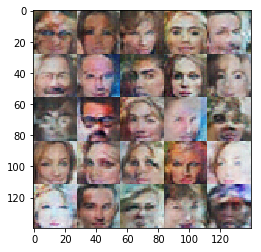

Epoch 1/1... Discriminator Loss: 2.4367... Generator Loss: 0.1140
Epoch 1/1... Discriminator Loss: 2.0102... Generator Loss: 0.2104
Epoch 1/1... Discriminator Loss: 1.9651... Generator Loss: 0.2060
Epoch 1/1... Discriminator Loss: 1.7500... Generator Loss: 0.3286
Epoch 1/1... Discriminator Loss: 2.6085... Generator Loss: 0.2238
Epoch 1/1... Discriminator Loss: 2.2346... Generator Loss: 0.2066
Epoch 1/1... Discriminator Loss: 1.7622... Generator Loss: 0.4030
Epoch 1/1... Discriminator Loss: 2.7099... Generator Loss: 0.0816
Epoch 1/1... Discriminator Loss: 2.2201... Generator Loss: 0.1960
Epoch 1/1... Discriminator Loss: 2.0847... Generator Loss: 0.2329


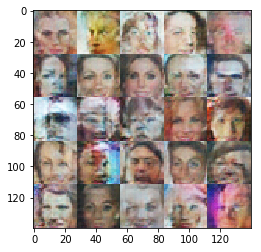

Epoch 1/1... Discriminator Loss: 2.1141... Generator Loss: 0.1905
Epoch 1/1... Discriminator Loss: 2.0899... Generator Loss: 0.2083
Epoch 1/1... Discriminator Loss: 1.8013... Generator Loss: 0.3044
Epoch 1/1... Discriminator Loss: 2.2619... Generator Loss: 0.1595
Epoch 1/1... Discriminator Loss: 2.0912... Generator Loss: 0.1899
Epoch 1/1... Discriminator Loss: 1.7021... Generator Loss: 0.3552
Epoch 1/1... Discriminator Loss: 1.8429... Generator Loss: 0.2503
Epoch 1/1... Discriminator Loss: 1.7710... Generator Loss: 0.3156
Epoch 1/1... Discriminator Loss: 2.0589... Generator Loss: 0.1839
Epoch 1/1... Discriminator Loss: 2.0600... Generator Loss: 0.4101


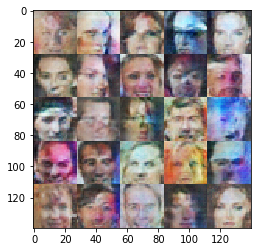

Epoch 1/1... Discriminator Loss: 2.0004... Generator Loss: 0.2645
Epoch 1/1... Discriminator Loss: 2.0654... Generator Loss: 0.2313
Epoch 1/1... Discriminator Loss: 2.0281... Generator Loss: 0.2144
Epoch 1/1... Discriminator Loss: 1.7796... Generator Loss: 0.3449
Epoch 1/1... Discriminator Loss: 2.1400... Generator Loss: 0.1690
Epoch 1/1... Discriminator Loss: 1.9767... Generator Loss: 0.1847
Epoch 1/1... Discriminator Loss: 1.5784... Generator Loss: 1.1455
Epoch 1/1... Discriminator Loss: 1.9555... Generator Loss: 0.2676
Epoch 1/1... Discriminator Loss: 2.3832... Generator Loss: 0.1346
Epoch 1/1... Discriminator Loss: 1.8893... Generator Loss: 0.3290


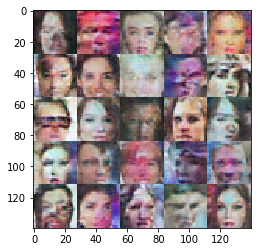

Epoch 1/1... Discriminator Loss: 1.8383... Generator Loss: 0.2323
Epoch 1/1... Discriminator Loss: 1.9049... Generator Loss: 0.2535
Epoch 1/1... Discriminator Loss: 2.3935... Generator Loss: 0.1248
Epoch 1/1... Discriminator Loss: 2.3122... Generator Loss: 0.1438
Epoch 1/1... Discriminator Loss: 2.1053... Generator Loss: 0.1676
Epoch 1/1... Discriminator Loss: 1.9539... Generator Loss: 0.3163
Epoch 1/1... Discriminator Loss: 2.5037... Generator Loss: 0.1081
Epoch 1/1... Discriminator Loss: 2.3180... Generator Loss: 0.1593
Epoch 1/1... Discriminator Loss: 1.6641... Generator Loss: 0.3815
Epoch 1/1... Discriminator Loss: 1.9979... Generator Loss: 0.2201


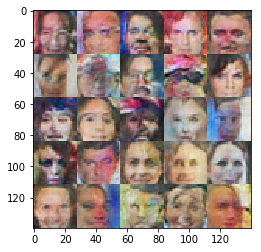

Epoch 1/1... Discriminator Loss: 1.7404... Generator Loss: 0.2988
Epoch 1/1... Discriminator Loss: 2.0321... Generator Loss: 0.2667
Epoch 1/1... Discriminator Loss: 2.1734... Generator Loss: 0.1959
Epoch 1/1... Discriminator Loss: 2.1224... Generator Loss: 0.1654
Epoch 1/1... Discriminator Loss: 1.8650... Generator Loss: 0.5283
Epoch 1/1... Discriminator Loss: 1.6309... Generator Loss: 0.4892
Epoch 1/1... Discriminator Loss: 2.1609... Generator Loss: 0.1842
Epoch 1/1... Discriminator Loss: 1.9540... Generator Loss: 0.2337
Epoch 1/1... Discriminator Loss: 1.9748... Generator Loss: 0.2016
Epoch 1/1... Discriminator Loss: 2.2106... Generator Loss: 0.1824


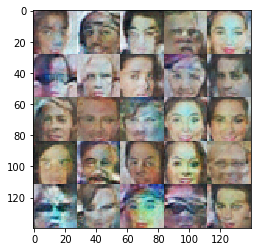

Epoch 1/1... Discriminator Loss: 1.9986... Generator Loss: 0.2481
Epoch 1/1... Discriminator Loss: 2.1622... Generator Loss: 0.1548
Epoch 1/1... Discriminator Loss: 1.9411... Generator Loss: 0.2814
Epoch 1/1... Discriminator Loss: 2.1945... Generator Loss: 0.1577
Epoch 1/1... Discriminator Loss: 2.1197... Generator Loss: 0.2329
Epoch 1/1... Discriminator Loss: 1.8132... Generator Loss: 0.3537
Epoch 1/1... Discriminator Loss: 2.1658... Generator Loss: 0.2542
Epoch 1/1... Discriminator Loss: 2.3674... Generator Loss: 0.1173
Epoch 1/1... Discriminator Loss: 1.7953... Generator Loss: 0.4043
Epoch 1/1... Discriminator Loss: 2.0568... Generator Loss: 0.2037


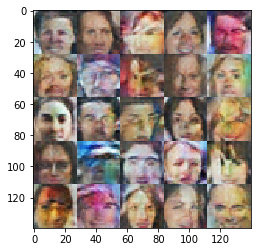

Epoch 1/1... Discriminator Loss: 2.0673... Generator Loss: 0.1894
Epoch 1/1... Discriminator Loss: 1.7291... Generator Loss: 0.3864
Epoch 1/1... Discriminator Loss: 2.0063... Generator Loss: 0.2496
Epoch 1/1... Discriminator Loss: 2.1735... Generator Loss: 0.1625
Epoch 1/1... Discriminator Loss: 2.1088... Generator Loss: 0.2332
Epoch 1/1... Discriminator Loss: 1.9125... Generator Loss: 0.2791
Epoch 1/1... Discriminator Loss: 2.0150... Generator Loss: 0.2297
Epoch 1/1... Discriminator Loss: 2.0391... Generator Loss: 0.2543
Epoch 1/1... Discriminator Loss: 2.2977... Generator Loss: 0.1283
Epoch 1/1... Discriminator Loss: 2.1573... Generator Loss: 0.1513


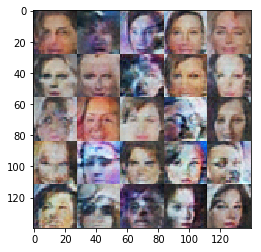

Epoch 1/1... Discriminator Loss: 2.3622... Generator Loss: 0.1150
Epoch 1/1... Discriminator Loss: 2.3247... Generator Loss: 0.1932
Epoch 1/1... Discriminator Loss: 2.0565... Generator Loss: 0.1776
Epoch 1/1... Discriminator Loss: 1.7900... Generator Loss: 0.4451
Epoch 1/1... Discriminator Loss: 1.9683... Generator Loss: 0.1906
Epoch 1/1... Discriminator Loss: 2.2463... Generator Loss: 0.1697
Epoch 1/1... Discriminator Loss: 2.2020... Generator Loss: 0.1543
Epoch 1/1... Discriminator Loss: 2.0839... Generator Loss: 0.1735
Epoch 1/1... Discriminator Loss: 1.6592... Generator Loss: 0.3305
Epoch 1/1... Discriminator Loss: 2.0007... Generator Loss: 0.2802


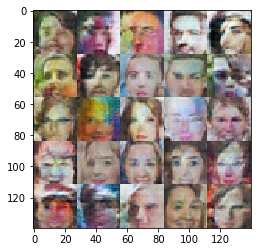

Epoch 1/1... Discriminator Loss: 2.6228... Generator Loss: 0.1197
Epoch 1/1... Discriminator Loss: 1.8349... Generator Loss: 0.3344
Epoch 1/1... Discriminator Loss: 2.1591... Generator Loss: 0.1627
Epoch 1/1... Discriminator Loss: 1.7744... Generator Loss: 0.3636
Epoch 1/1... Discriminator Loss: 2.3497... Generator Loss: 0.2648
Epoch 1/1... Discriminator Loss: 2.2315... Generator Loss: 0.1583
Epoch 1/1... Discriminator Loss: 1.9192... Generator Loss: 0.2240
Epoch 1/1... Discriminator Loss: 1.8893... Generator Loss: 0.2014
Epoch 1/1... Discriminator Loss: 2.3406... Generator Loss: 0.1377
Epoch 1/1... Discriminator Loss: 2.2165... Generator Loss: 0.2083


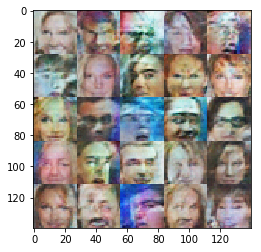

Epoch 1/1... Discriminator Loss: 2.0591... Generator Loss: 0.4232
Epoch 1/1... Discriminator Loss: 2.1322... Generator Loss: 0.1760
Epoch 1/1... Discriminator Loss: 2.2432... Generator Loss: 0.1700


In [40]:
# batch_size = None
# z_dim = None
# learning_rate = None
# beta1 = None
batch_size = 32 #32
z_dim = 300 #150
learning_rate = 0.0005
beta1 = 0.3

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

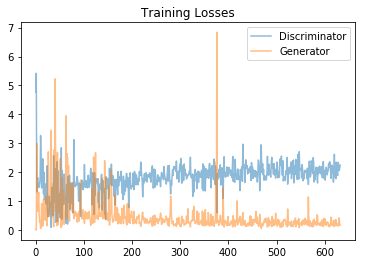

In [41]:
plt = pyplot
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.